In [7]:
from random import random
import numpy as np
import trace_gen as tg # source code at: https://github.com/Effygal/trace-gen
import matplotlib.pyplot as plt
import heapq
import seaborn as sns
import pandas as pd
import itertools
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
plt.rcParams['pdf.fonttype'] = 42 
plt.rcParams['ps.fonttype'] = 42 
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['text.usetex']  = False
palette = sns.color_palette("deep", n_colors=13)
np.random.seed(44)

In [18]:
def gen_from_zipf(M, n, a):
    p = 1.0 / np.power(np.arange(1, M + 1), a)
    p = p / p.sum()
    return np.random.choice(M, size=n, p=p)

def gen_ph(m, theta, length):
    p = 1.0 / np.power(np.arange(1, m + 1), theta)
    p = p / p.sum()
    cp = np.cumsum(p)
    t = p.copy()
    phases = np.searchsorted(cp, np.random.random(m), side="right")
    next_times = np.random.exponential(1.0 / t[phases])
    heap = [(next_times[i], i) for i in range(m)]
    heapq.heapify(heap)
    trace = np.empty(length, dtype=np.int32)
    for idx in range(length):
        ctime, item = heapq.heappop(heap)
        trace[idx] = item + 1
        phases[item] = np.searchsorted(cp, np.random.random(), side="right")
        next_time = ctime + np.random.exponential(1.0 / t[phases[item]])
        heapq.heappush(heap, (next_time, item))
    return trace

def gen_ph_2class(n, theta, ratio, length, mu_ratio=None):
    """
    If mu_ratio is provided, mu1/mu2=mu_ratio with mean inter-arrival 1/2*(1/mu1+1/mu2)=1.
    Otherwise use T=[[-1,0],[0,-ratio]].
    """
    p = 1.0 / np.power(np.arange(1, n + 1), theta)
    p /= p.sum()

    alpha0 = alpha1 = 0.5
    alpha = np.array([alpha0, alpha1], dtype=float)

    if mu_ratio is not None:
        mu2 = (1.0 / mu_ratio + 1.0) / 2.0
        mu1 = mu_ratio * mu2
        T = np.array([[-mu1, 0.0], [0.0, -mu2]], dtype=float)
    elif ratio is not None:
        T = np.array([[-1.0, 0.0], [0.0, -float(ratio)]], dtype=float)
    else:
        raise ValueError("Provide ratio or mu_ratio")

    t = -T.sum(axis=1)
    B = T + t[:, None] * alpha[None, :]
    scale = np.max(-np.diag(B))
    P = B / scale + np.eye(2)
    a = P[0, 1]
    b = P[1, 0]
    if a + b == 0:
        beta = np.array([0.5, 0.5], dtype=float)
    else:
        beta = np.array([b / (a + b), a / (a + b)], dtype=float)
    arate = beta.dot(t)
    T = T / arate
    t = t / arate

    phases = (np.random.random(n) >= alpha0).astype(np.int8)
    rates = t[phases] * p
    next_times = np.random.exponential(1.0 / rates)
    heap = [(next_times[i], i) for i in range(n)]
    heapq.heapify(heap)
    trace = np.empty(length, dtype=np.int32)
    for idx in range(length):
        ctime, item = heapq.heappop(heap)
        trace[idx] = item + 1
        phases[item] = 0 if np.random.random() < alpha0 else 1
        rate = t[phases[item]] * p[item]
        next_time = ctime + np.random.exponential(1.0 / rate)
        heapq.heappush(heap, (next_time, item))
    return trace


In [19]:

def irm_fixed_point_fast(n, theta, cache_size, K=1, tol=1e-15, max_iter=200):
    p = 1.0 / np.power(np.arange(1, n + 1, dtype=np.float64), theta)
    p /= p.sum()
    target = n - float(cache_size)
    if target <= 0:
        return 1.0, np.zeros_like(p), 0.0

    low, high = 0.0, 1.0
    x_minus1 = None
    for _ in range(max_iter):
        z = 0.5 * (low + high)
        r = p / z
        
        denom = np.where(
            np.abs(r - 1.0) < 1e-12,
            K + 2.0,
            (1.0 - r**(K + 2)) / (1.0 - r)
        )
        x_minus1 = 1.0 / denom
        diff = x_minus1.sum() - target
        if high - low <= tol:
            break
        if diff > 0:
            high = z
        else:
            low = z
    pmiss = np.dot(p, 1.0 / denom) 
    return z, x_minus1, pmiss

def he_fixed_point_fast(C, K, n, theta, tol=1e-12, max_iter=60):
    if not (0 < C < n):
        raise ValueError("C must be between 0 and n")
    dtype = np.longdouble if np.finfo(np.longdouble).max > np.finfo(np.float64).max else np.float64
    p = 1.0 / np.power(np.arange(1, n + 1, dtype=np.float64), theta)
    p /= p.sum()
    alpha = p
    inv_p = 1.0 / p
    ones = np.ones(n, float)
    target = 1.0 - C / n
    eps = 1e-15

    def prepare(z):
        di = 1.0 / (p + z)              # 1 ./ (p + z)
        z_di = z * di                  # z ./ (p + z)
        alpha_di = alpha * di
        denom = 1.0 - z * np.dot(alpha, di)
        if abs(denom) < eps:
            denom = eps if denom >= 0 else -eps
        return di, z_di, alpha_di, denom

    def R_dot(v, z, di, z_di, alpha_di, denom):
        # R = z*diag(di) + (z/denom) * (z*di) (alpha*di)^T
        outer_scale = (z / denom) * np.dot(alpha_di, v)
        return z_di * v + outer_scale * z_di

    def solve_eye_minus_R(b, z, di, z_di, alpha_di, denom):
        # Solve (I - R) x = b using Sherman-Morrison on a diagonal + rank-1 matrix.
        B_inv = 1.0 / (1.0 - z_di)  # diagonal inverse of I - z*diag(di)
        u = (z / denom) * z_di
        v = alpha_di
        B_inv_u = B_inv * u
        B_inv_b = B_inv * b
        denom2 = 1.0 - np.dot(v, B_inv_u)
        if abs(denom2) < eps:
            denom2 = eps if denom2 >= 0 else -eps
        return B_inv_b + B_inv_u * (np.dot(v, B_inv_b) / denom2)

    def R_power_vec(v, power, z, di, z_di, alpha_di, denom):
        for _ in range(power):
            v = R_dot(v, z, di, z_di, alpha_di, denom)
        return v

    lo, hi = 1e-12, 0.999999
    z_star = 0.5 * (lo + hi)
    for _ in range(max_iter):
        z_mid = 0.5 * (lo + hi)
        di, z_di, alpha_di, denom = prepare(z_mid)
        theta_k = alpha_di

        tmp_vec = z_mid * R_power_vec(inv_p, K, z_mid, di, z_di, alpha_di, denom)
        w = solve_eye_minus_R(ones, z_mid, di, z_di, alpha_di, denom)
        tmp2 = w - R_power_vec(w, K + 1, z_mid, di, z_di, alpha_di, denom)

        denom_chk = np.dot(theta_k, tmp_vec + tmp2)
        num_chk = np.dot(theta_k, tmp_vec)
        check = num_chk / denom_chk

        if hi - lo <= tol:
            z_star = z_mid
            break
        if check < target:
            lo = z_mid
        else:
            hi = z_mid
        z_star = z_mid

    di, z_di, alpha_di, denom = prepare(z_star)
    theta_k = alpha_di
    tmp_vec = z_star * R_power_vec(inv_p, K, z_star, di, z_di, alpha_di, denom)
    w = solve_eye_minus_R(ones, z_star, di, z_di, alpha_di, denom)
    tmp2 = w - R_power_vec(w, K + 1, z_star, di, z_di, alpha_di, denom)

    denom_base = np.dot(theta_k, tmp_vec + tmp2)
    num_x = np.dot(theta_k, tmp_vec)
    x_minus1_scalar = num_x / denom_base
    x_minus1 = np.full(n, x_minus1_scalar, float)

    rkv_ones = R_power_vec(ones, K, z_star, di, z_di, alpha_di, denom)
    pmiss = n * np.dot(theta_k, z_star * rkv_ones) / denom_base
    return z_star, x_minus1, pmiss


def ph_2class_fixed_point_fast(C, K, n, theta, ratio=None, mu_ratio=None, tol=1e-12, max_iter=60):
    if not (0 < C < n):
        raise ValueError("C must be between 0 and n")
    dtype = np.longdouble if np.finfo(np.longdouble).max > np.finfo(np.float64).max else np.float64
    p = 1.0 / np.power(np.arange(1, n + 1, dtype=dtype), theta, dtype=dtype)
    p /= p.sum(dtype=dtype)

    alpha0 = alpha1 = dtype(0.5)
    alpha_vec = np.array([alpha0, alpha1], dtype=dtype)

    if mu_ratio is not None:
        mu2 = (1.0 / mu_ratio + 1.0) / 2.0
        mu1 = mu_ratio * mu2
        T = np.array([[-mu1, 0.0], [0.0, -mu2]], dtype=dtype)
    elif ratio is not None:
        T = np.array([[-1.0, 0.0], [0.0, -float(ratio)]], dtype=dtype)
    else:
        raise ValueError

    t_vec = -T.sum(axis=1)
    T = T.astype(dtype)
    t_vec = t_vec.astype(dtype)
    B = T + t_vec[:, None] * alpha_vec[None, :]
    scale = np.max(-np.diag(B))
    P = B / scale + np.eye(2)
    denom_stat = P[0, 1] + P[1, 0]
    if abs(denom_stat) < 1e-18:
        beta0 = beta1 = dtype(0.5)
    else:
        beta0 = P[1, 0] / denom_stat
        beta1 = dtype(1.0) - beta0
    arate = beta0 * t_vec[0] + beta1 * t_vec[1]
    T = T / arate
    t_vec = t_vec / arate
    t0, t1 = t_vec
    T00, T11 = T[0, 0], T[1, 1]

    eps = dtype(1e-14)
    clip_val = np.finfo(dtype).max / dtype(4.0)
    target = dtype(n - C)

    def compute_R(z):
        z = dtype(z)
        with np.errstate(over="ignore", invalid="ignore", divide="ignore"):
            a00 = T00 * p - dtype(0.5) * z
            a11 = T11 * p - dtype(0.5) * z
            det = a00 * a11 - (dtype(0.5) * z) ** 2
            det = np.where(np.abs(det) < eps, np.sign(det) * eps + eps, det)
            coef = -z / det
            r00 = coef * a11
            r11 = coef * a00
            off = (z * z * dtype(0.5)) / det
            r01 = off
            r10 = off
            rp00, rp01, rp10, rp11 = r00, r01, r10, r11
            for _ in range(max(K - 1, 0)):
                rp00, rp01, rp10, rp11 = (
                    np.clip(rp00 * r00 + rp01 * r10, -clip_val, clip_val),
                    np.clip(rp00 * r01 + rp01 * r11, -clip_val, clip_val),
                    np.clip(rp10 * r00 + rp11 * r10, -clip_val, clip_val),
                    np.clip(rp10 * r01 + rp11 * r11, -clip_val, clip_val),
                )
            rp00 = np.nan_to_num(rp00, nan=0.0, posinf=clip_val, neginf=-clip_val)
            rp01 = np.nan_to_num(rp01, nan=0.0, posinf=clip_val, neginf=-clip_val)
            rp10 = np.nan_to_num(rp10, nan=0.0, posinf=clip_val, neginf=-clip_val)
            rp11 = np.nan_to_num(rp11, nan=0.0, posinf=clip_val, neginf=-clip_val)
            return (r00, r01, r10, r11), (rp00, rp01, rp10, rp11)

    def check_for_z(z):
        with np.errstate(over="ignore", invalid="ignore", divide="ignore"):
            (r00, r01, r10, r11), (rp00, rp01, rp10, rp11) = compute_R(z)
            inv0 = -dtype(1.0) / (T00 * p)
            inv1 = -dtype(1.0) / (T11 * p)
            th0 = -alpha0 / (T00 * p - z)
            th1 = -alpha1 / (T11 * p - z)

            tmp0 = z * (rp00 * inv0 + rp01 * inv1)
            tmp0 = np.nan_to_num(tmp0, nan=0.0, posinf=clip_val, neginf=-clip_val)
            tmp1 = z * (rp10 * inv0 + rp11 * inv1)
            tmp1 = np.nan_to_num(tmp1, nan=0.0, posinf=clip_val, neginf=-clip_val)

            det_imr = (dtype(1.0) - r00) * (dtype(1.0) - r11) - r01 * r10
            det_imr = np.where(np.abs(det_imr) < eps, np.sign(det_imr) * eps + eps, det_imr)
            inv00 = (dtype(1.0) - r11) / det_imr
            inv01 = r01 / det_imr
            inv10 = r10 / det_imr
            inv11 = (dtype(1.0) - r00) / det_imr
            s0 = inv00 + inv01
            s1 = inv10 + inv11

            pr00 = rp00 * r00 + rp01 * r10
            pr01 = rp00 * r01 + rp01 * r11
            pr10 = rp10 * r00 + rp11 * r10
            pr11 = rp10 * r01 + rp11 * r11
            pr00 = np.clip(pr00, -clip_val, clip_val)
            pr01 = np.clip(pr01, -clip_val, clip_val)
            pr10 = np.clip(pr10, -clip_val, clip_val)
            pr11 = np.clip(pr11, -clip_val, clip_val)
            tmp2_0 = (dtype(1.0) - pr00) * s0 - pr01 * s1
            tmp2_1 = -pr10 * s0 + (dtype(1.0) - pr11) * s1
            tmp2_0 = np.nan_to_num(tmp2_0, nan=0.0, posinf=clip_val, neginf=-clip_val)
            tmp2_1 = np.nan_to_num(tmp2_1, nan=0.0, posinf=clip_val, neginf=-clip_val)

            num = th0 * tmp0 + th1 * tmp1
            den = th0 * (tmp0 + tmp2_0) + th1 * (tmp1 + tmp2_1)
            return np.sum(num / den)

    lo, hi = dtype(1e-12), dtype(0.999999)
    z_star = dtype(0.5) * (lo + hi)
    for _ in range(max_iter):
        z_mid = dtype(0.5) * (lo + hi)
        chk = check_for_z(z_mid)
        if hi - lo <= tol:
            z_star = z_mid
            break
        if chk < target:
            lo = z_mid
        else:
            hi = z_mid
        z_star = z_mid

    (r00, r01, r10, r11), (rp00, rp01, rp10, rp11) = compute_R(z_star)
    inv0 = -dtype(1.0) / (T00 * p)
    inv1 = -dtype(1.0) / (T11 * p)
    th0 = -alpha0 / (T00 * p - z_star)
    th1 = -alpha1 / (T11 * p - z_star)

    det_imr = (dtype(1.0) - r00) * (dtype(1.0) - r11) - r01 * r10
    det_imr = np.where(np.abs(det_imr) < eps, np.sign(det_imr) * eps + eps, det_imr)
    inv00 = (dtype(1.0) - r11) / det_imr
    inv01 = r01 / det_imr
    inv10 = r10 / det_imr
    inv11 = (dtype(1.0) - r00) / det_imr
    s0 = inv00 + inv01
    s1 = inv10 + inv11

    pr00 = rp00 * r00 + rp01 * r10
    pr01 = rp00 * r01 + rp01 * r11
    pr10 = rp10 * r00 + rp11 * r10
    pr11 = rp10 * r01 + rp11 * r11
    pr00 = np.clip(pr00, -clip_val, clip_val)
    pr01 = np.clip(pr01, -clip_val, clip_val)
    pr10 = np.clip(pr10, -clip_val, clip_val)
    pr11 = np.clip(pr11, -clip_val, clip_val)
    tmp2_0 = (dtype(1.0) - pr00) * s0 - pr01 * s1
    tmp2_1 = -pr10 * s0 + (dtype(1.0) - pr11) * s1
    tmp2_0 = np.nan_to_num(tmp2_0, nan=0.0, posinf=clip_val, neginf=-clip_val)
    tmp2_1 = np.nan_to_num(tmp2_1, nan=0.0, posinf=clip_val, neginf=-clip_val)

    tmpM00 = z_star * rp00 * inv0
    tmpM01 = z_star * rp01 * inv1
    tmpM10 = z_star * rp10 * inv0
    tmpM11 = z_star * rp11 * inv1
    tmp_sum0 = tmpM00 + tmpM01
    tmp_sum1 = tmpM10 + tmpM11

    tmpMt0 = tmpM00 * t0 + tmpM01 * t1
    tmpMt1 = tmpM10 * t0 + tmpM11 * t1

    denom_base = th0 * (tmp_sum0 + tmp2_0) + th1 * (tmp_sum1 + tmp2_1)
    num_x = th0 * tmp_sum0 + th1 * tmp_sum1
    x_minus1_scalar = np.sum(num_x / denom_base)
    x_minus1 = np.full(n, x_minus1_scalar, float)

    miss = np.sum((th0 * tmpMt0 + th1 * tmpMt1) * p / denom_base)
    return z_star, x_minus1, miss


In [10]:
# ms = [100, 500, 1000]
ms = [30, 60, 120, 240, 480, 960]
ns = [10000000]
thetas = [0.5, 0.8, 1.1]
ks = [1, 15, 63]
mu_ratio = 10.0
records, errors = [], []

for m in ms:
    for n in ns:
        for a in thetas:
            trace1 = gen_from_zipf(m, n, a)
            # trace2 = gen_ph(m, a, n)
            trace3 = gen_ph_2class(m, a, ratio=None, length=n, mu_ratio=mu_ratio)
            c_vals = np.unique(np.round(np.linspace(m//100+1, m-1, 20)).astype(int))

            for c in c_vals:
                for k in ks:
                    rclock1 = tg.ran_clock(c, k)
                    rclock1.run(trace1)
                    mr_irm_sim = 1 - rclock1.hitrate()
                    # mr_irm_sim = 1-tg.sim_ran_clock(c, trace1, raw=False, K=k)


                    # rclock2 = tg.ran_clock(c, k)
                    # rclock2.run(trace2, rp=True)
                    # mr_he_sim = 1 - rclock2.hitrate()

                    rclock3 = tg.ran_clock(c, k)
                    rclock3.run(trace3)
                    mr_ph2_sim = 1 - rclock3.hitrate()
                    # mr_ph2_sim = 1-tg.sim_ran_clock(c, trace3, raw=False, K=k)

                    mr_irm_model = irm_fixed_point_fast(m, a, c, K=k)[2]
                    # mr_he_model = he_fixed_point_fast(c, k, m, a)[2]
                    mr_ph2_model = ph_2class_fixed_point_fast(c, k, m, a, mu_ratio=mu_ratio)[2]

                    records.append({
                        "m": m, "n": n, "alpha": a, "C": c, "K": k,
                        "mr_irm_sim": mr_irm_sim,
                        # "mr_he_sim": mr_he_sim,
                        "mr_ph2_sim": mr_ph2_sim,
                        "mr_irm_model": mr_irm_model,
                        # "mr_he_model": mr_he_model,
                        "mr_ph2_model": mr_ph2_model,
                    })

                    errors.append({
                        "m": m, "n": n, "alpha": a, "C": c, "K": k,
                        "error_irm": abs(mr_irm_sim - mr_irm_model),
                        # "error_he": abs(mr_he_sim - mr_he_model),
                        "error_ph2": abs(mr_ph2_sim - mr_ph2_model),
                    })

df_mr = pd.DataFrame(records)
df_err = pd.DataFrame(errors)


In [12]:
df_mr.to_csv("data/mrcs.csv", index=True)
df_err.to_csv("data/maes.csv", index=True)

# df_mr = pd.read_csv("data/mrcs.csv")
# df_err = pd.read_csv("data/maes.csv")

/tmp/ipykernel_2769712/3589128992.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(order, fontsize=font_ticks, rotation=0)
/tmp/ipykernel_2769712/3589128992.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(order, fontsize=font_ticks, rotation=0)
/tmp/ipykernel_2769712/3589128992.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(order, fontsize=font_ticks, rotation=0)
/tmp/ipykernel_2769712/3589128992.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(order, fontsize=font_ticks, rotation=0)
/tmp/ipykernel_2769712/3589128992.py:66: UserWarning: set_ticklabels() shoul

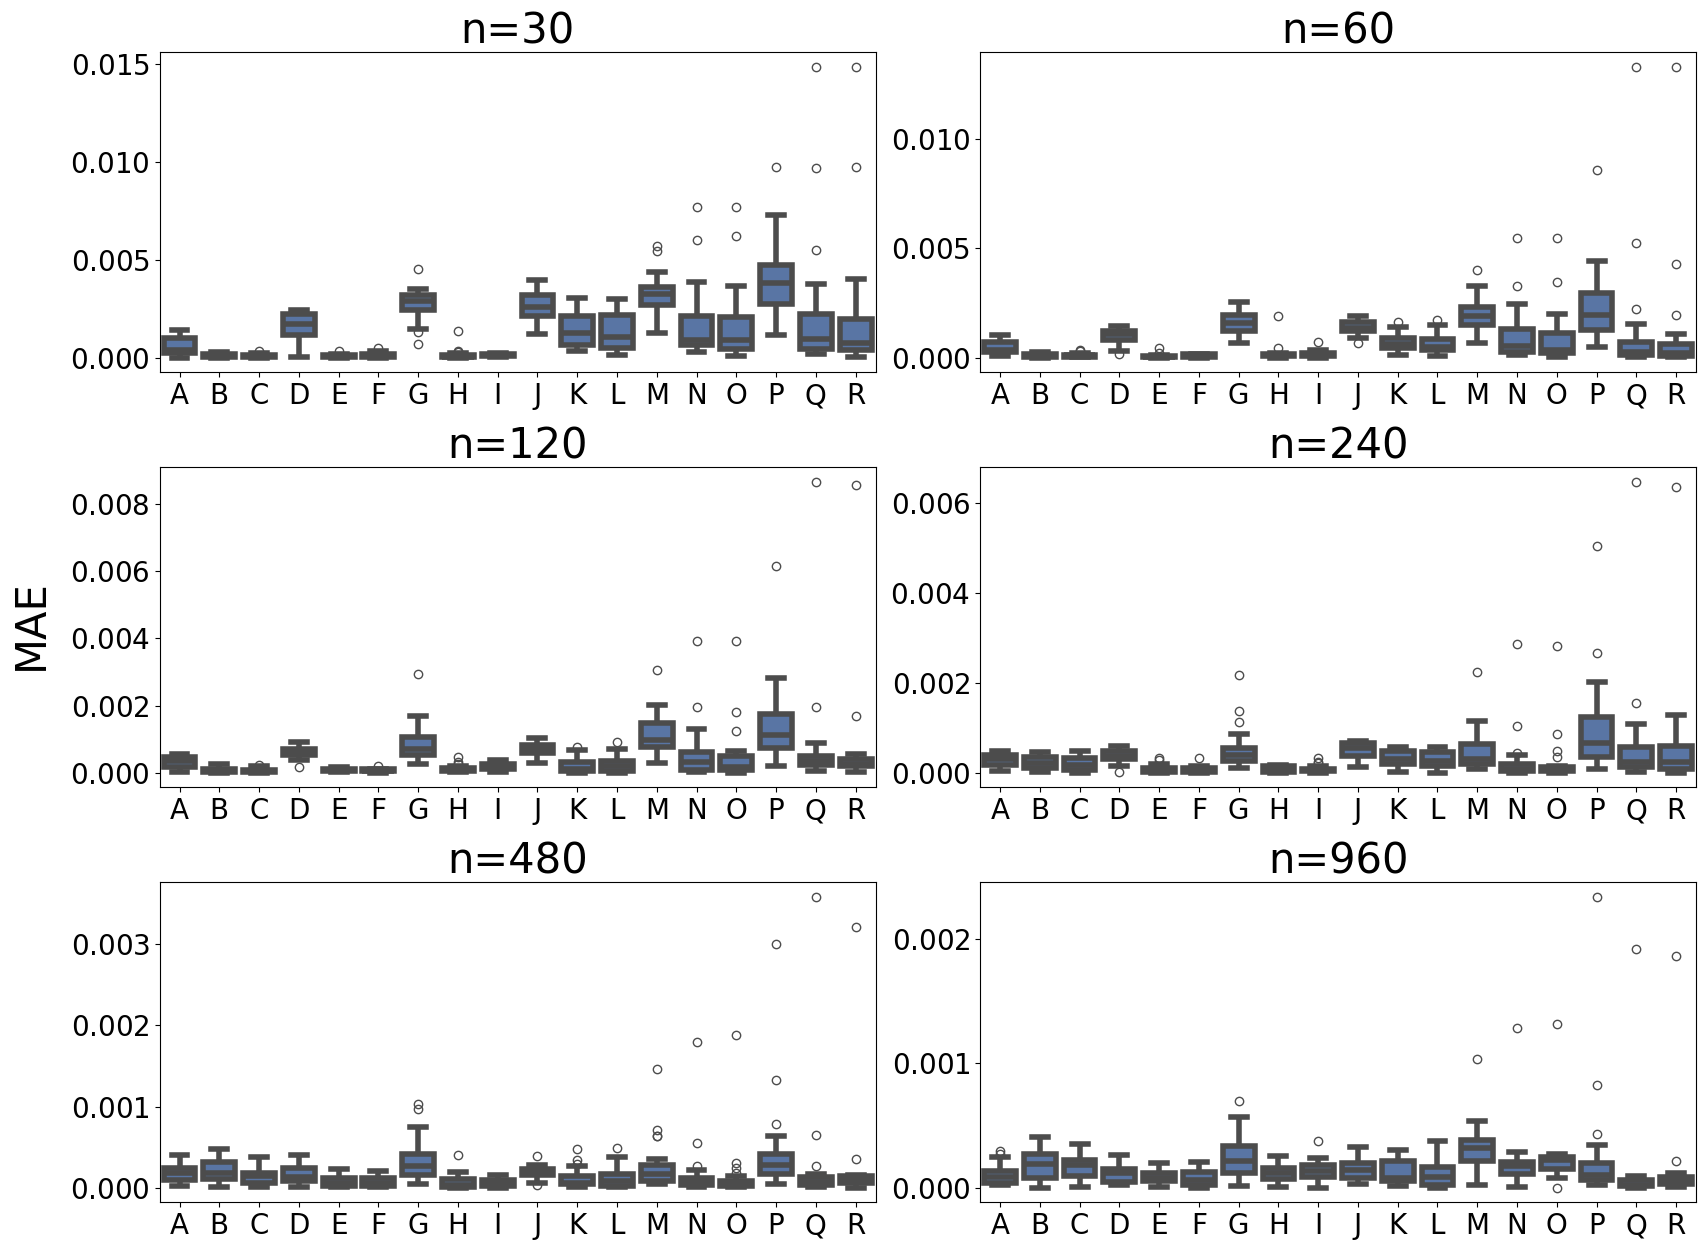

In [11]:

from matplotlib.ticker import ScalarFormatter

alphas = sorted(df_mr["alpha"].unique())
ks = sorted(df_mr["K"].unique())

labels_irm = ['A','B','C','D','E','F','G','H','I']
# labels_he  = ['J','K','L','M','N','O','P','Q','R']
labels_ph2 = ['J','K','L','M','N','O','P','Q','R']
# labels = labels_irm + labels_he + labels_ph2
labels = labels_irm + labels_ph2

# wkls = ['IRM', 'HE', 'PH2']
wkls = ['IRM', 'PH2']
pairs = list(itertools.product(wkls, alphas, ks))

sns.set_palette("deep")
font_axes = 30
font_ticks = 20
line_width = 4
palette = sns.color_palette("deep", len(labels))
color_map = dict(zip(labels, palette))

mapping = {pk: lab for pk, lab in zip(pairs, labels)}
order = labels

rows = []
for r in df_err.itertuples():
    rows.append({
        "m": r.m, "n": r.n, "C": r.C,
        "workload": "IRM",
        "error": r.error_irm,
        "method_param": ("IRM", r.alpha, r.K)
    })
    # rows.append({
    #     "m": r.m, "n": r.n, "C": r.C,
    #     "workload": "HE",
    #     "error": r.error_he,
    #     "method_param": ("HE", r.alpha, r.K)
    # })
    rows.append({
        "m": r.m, "n": r.n, "C": r.C,
        "workload": "PH2",
        "error": r.error_ph2,
        "method_param": ("PH2", r.alpha, r.K)
    })
df_err = pd.DataFrame(rows)
df_err["short"] = df_err["method_param"].map(mapping)

M_list = ms
n_list = ns

subplot_rows, subplot_cols = 3, 2
fig2, axes2 = plt.subplots(subplot_rows, subplot_cols, figsize=(18, 14),
                           sharex=False, sharey=False)
axes_flat = axes2.flatten()

for ax2, (M, n) in zip(axes_flat, itertools.product(M_list, n_list)):
    cell = df_err[(df_err.m == M) & (df_err.n == n)].copy()
    sns.boxplot(x='short', y='error', data=cell, ax=ax2,
                linewidth=line_width, order=order)
    ax2.set_title(f"n={M}", fontsize=font_axes)
    ax2.tick_params(labelsize=font_ticks)
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax2.set_xticklabels(order, fontsize=font_ticks, rotation=0)

fig2.text(0.025, 0.5, 'MAE', va='center', rotation='vertical',
          fontsize=font_axes)

plt.tight_layout(rect=[0.05, 0.05, 0.97, 0.95])
# plt.savefig("figures/ranclock-maes.pdf", bbox_inches='tight')
plt.show()


In [20]:
def sim_clock(trace, cnt):
    M = len(set(trace))
    K = M // 20
    c = np.arange(2, M+1, K)
    hr_clock = [tg.sim_clock(int(_c), trace, raw=True, K=cnt) for _c in c]
    return c, hr_clock

def sim_ran_clock(trace, cnt):
    M = len(set(trace))
    K = M // 20
    c = np.arange(2, M+1, K)
    hr_ran_clock = [tg.sim_ran_clock(int(_c), trace, raw=True, K=cnt, seed=44) for _c in c]
    return c, hr_ran_clock

def sim_fifo_m(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(2, M+1, K)
    hr_fifo_m = [tg.sim_fifo_m([int(s)//2, int(s) - int(s)//2], trace, raw=True) for s in c] 
    return c, hr_fifo_m

def sim_rand_m(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(2, M+1, K)
    hr_rand_m = [tg.sim_rand_m([int(s)//2, int(s) - int(s)//2], trace, raw=True) for s in c] 
    return c, hr_rand_m

def sim_sieve(trace, cnt):
    M = len(set(trace))
    K = M // 20
    c = np.arange(2, M+1, K)
    hr_sieve = [tg.sim_sieve(int(_c), trace, raw=True, K=cnt) for _c in c]
    return c, hr_sieve

def sim_ran_sieve(trace, cnt):
    M = len(set(trace))
    K = M // 20
    c = np.arange(2, M+1, K)
    hr_ran_sieve = [tg.sim_ran_sieve(int(_c), trace, raw=True, K=cnt, seed=44) for _c in c]
    return c, hr_ran_sieve

def sim_lru(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(2, M, K)
    hr_lru = [tg.sim_lru(int(_c), trace, raw=True) for _c in c]
    return c, hr_lru

def sim_fifo(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(2, M, K)
    hr_fifo = [tg.sim_fifo(int(_c), trace, raw=True) for _c in c]
    return c, hr_fifo

def sim_min(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(2, M+1, K)
    hr_min = [tg.sim_min(int(_c), trace, raw=True) for _c in c]
    return c, hr_min

def gen_from_zipf(M, n, a):
    p = 1.0 / np.power(np.arange(1, M + 1), a)
    p = p / p.sum()
    return p, np.random.choice(M, size=n, p=p)

def gen_ph(m, theta, length):
    p = 1.0 / np.power(np.arange(1, m + 1), theta)
    p = p / p.sum()
    cp = np.cumsum(p)
    t = p.copy()
    phases = np.searchsorted(cp, np.random.random(m), side="right")
    next_times = np.random.exponential(1.0 / t[phases])
    heap = [(next_times[i], i) for i in range(m)]
    heapq.heapify(heap) 
    trace = np.empty(length, dtype=np.int32)
    for idx in range(length):
        ctime, item = heapq.heappop(heap)
        trace[idx] = item + 1
        phases[item] = np.searchsorted(cp, np.random.random(), side="right")
        next_time = ctime + np.random.exponential(1.0 / t[phases[item]])
        heapq.heappush(heap, (next_time, item))
    return trace

def gen_ph_2class(n, theta, length, mu_ratio=10.0):
    p = 1.0 / np.power(np.arange(1, n + 1), theta)
    p /= p.sum()
    alpha0 = 0.5
    alpha = np.array([0.5, 0.5], dtype=float)
    mu2 = (1.0 / mu_ratio + 1.0) / 2.0
    mu1 = mu_ratio * mu2
    T = np.array([[-mu1, 0.0], [0.0, -mu2]], dtype=float)
    t = -T.sum(axis=1)
    B = T + t[:, None] * alpha[None, :]
    scale = np.max(-np.diag(B))
    P = B / scale + np.eye(2)
    a, b = P[0, 1], P[1, 0]
    beta = np.array([0.5, 0.5], dtype=float) if a + b == 0 else np.array([b / (a + b), a / (a + b)], dtype=float)
    arate = beta.dot(t)
    t /= arate
    phases = (np.random.random(n) >= alpha0).astype(np.int8)
    rates = t[phases] * p
    next_times = np.random.exponential(1.0 / rates)
    heap = [(next_times[i], i) for i in range(n)]
    heapq.heapify(heap)

    trace = np.empty(length, dtype=np.int32)
    for idx in range(length):
        ctime, item = heapq.heappop(heap)
        trace[idx] = item + 1
        phases[item] = 0 if np.random.random() < alpha0 else 1
        rate = t[phases[item]] * p[item]
        heapq.heappush(heap, (ctime + np.random.exponential(1.0 / rate), item))
    return trace

In [24]:
# lmb08, irm_08 = gen_from_zipf(120, 10000000, 0.8)
# ph_08 = gen_ph_2class(120, 0.8, 10000000, mu_ratio=10.0)
irm_08 = np.loadtxt('zipf_120_08_trace.txt', dtype=np.int32)
ph_08 = np.loadtxt('ph_120_08_trace.txt', dtype=np.int32)
# lmb11, irm_11 = gen_from_zipf(120, 10000000, 1.1)
# ph_11 = gen_ph_2class(120, 1.1, 10000000, mu_ratio=10.0)
irm_11 = np.loadtxt('zipf_120_11_trace.txt', dtype=np.int32)
ph_11 = np.loadtxt('ph_120_11_trace.txt', dtype=np.int32)

In [ ]:
# # sieve
# i08_cs1, i08_hrs1 = sim_sieve(irm_08, cnt=1)
# p08_cs1, p08_hrs1 = sim_sieve(ph_08, cnt=1)
# i11_cs1, i11_hrs1 = sim_sieve(irm_11, cnt=1)
# p11_cs1, p11_hrs1 = sim_sieve(ph_11, cnt=1)
# i08_cs15, i08_hrs15 = sim_sieve(irm_08, cnt=15)
# p08_cs15, p08_hrs15 = sim_sieve(ph_08, cnt=15)
# i11_cs15, i11_hrs15 = sim_sieve(irm_11, cnt=15)
# p11_cs15, p11_hrs15 = sim_sieve(ph_11, cnt=15)
# # ran-sieve
# i08_crs1, i08_hrcrs1 = sim_ran_sieve(irm_08, cnt=1)
# p08_crs1, p08_hrcrs1 = sim_ran_sieve(ph_08, cnt=1)
# i11_crs1, i11_hrcrs1 = sim_ran_sieve(irm_11, cnt=1)
# p11_crs1, p11_hrcrs1 = sim_ran_sieve(ph_11, cnt=1)
# i08_crs15, i08_hrcrs15 = sim_ran_sieve(irm_08, cnt=15)
# p08_crs15, p08_hrcrs15 = sim_ran_sieve(ph_08, cnt=15)
# i11_crs15, i11_hrcrs15 = sim_ran_sieve(irm_11, cnt=15)
# p11_crs15, p11_hrcrs15 = sim_ran_sieve(ph_11, cnt=15)
# # ran-clock
# i08_crc1, i08_hrcrc1 = sim_ran_clock(irm_08, cnt=1)
# p08_crc1, p08_hrcrc1 = sim_ran_clock(ph_08, cnt=1)
# i11_crc1, i11_hrcrc1 = sim_ran_clock(irm_11, cnt=1)
# p11_crc1, p11_hrcrc1 = sim_ran_clock(ph_11, cnt=1)
# i08_crc15, i08_hrcrc15 = sim_ran_clock(irm_08, cnt=15)
# p08_crc15, p08_hrcrc15 = sim_ran_clock(ph_08, cnt=15)
# i11_crc15, i11_hrcrc15 = sim_ran_clock(irm_11, cnt=15)
# p11_crc15, p11_hrcrc15 = sim_ran_clock(ph_11, cnt=15)
# # clock
# i08_ccc1, i08_hrccc1 = sim_clock(irm_08, cnt=1)
# p08_ccc1, p08_hrccc1 = sim_clock(ph_08, cnt=1)
# i11_ccc1, i11_hrccc1 = sim_clock(irm_11, cnt=1)
# p11_ccc1, p11_hrccc1 = sim_clock(ph_11, cnt=1)
# i08_ccc15, i08_hrccc15 = sim_clock(irm_08, cnt=15)
# p08_ccc15, p08_hrccc15 = sim_clock(ph_08, cnt=15)
# i11_ccc15, i11_hrccc15 = sim_clock(irm_11, cnt=15)
# p11_ccc15, p11_hrccc15 = sim_clock(ph_11, cnt=15)
# # fifo-m
# i08_cfm, i08_hrcfm = sim_fifo_m(irm_08)
# p08_cfm, p08_hrcfm = sim_fifo_m(ph_08)
# i11_cfm, i11_hrcfm = sim_fifo_m(irm_11)
# p11_cfm, p11_hrcfm = sim_fifo_m(ph_11)
# # rand-m
# i08crm, i08_hrcrm = sim_rand_m(irm_08)
# p08crm, p08_hrcrm = sim_rand_m(ph_08)
# i11crm, i11_hrcrm = sim_rand_m(irm_11)
# p11crm, p11_hrcrm = sim_rand_m(ph_11)
# # lru
# i08_clru, i08_hrclru = sim_lru(irm_08)
# p08_clru, p08_hrclru = sim_lru(ph_08)
# i11_clru, i11_hrclru = sim_lru(irm_11)
# p11_clru, p11_hrclru = sim_lru(ph_11)
# # fifo
# i08_cf, i08_hrcf = sim_fifo(irm_08)
# p08_cf, p08_hrcf = sim_fifo(ph_08)
# i11_cf, i11_hrcf = sim_fifo(irm_11)
# p11_cf, p11_hrcf = sim_fifo(ph_11)

In [28]:
# np.savez_compressed('data/mrcs_irm_08.npz',
#     c_sieve=i08_cs1, hr_sieve=i08_hrs1,
#     c_sieve15=i08_cs15, hr_sieve15=i08_hrs15,
#     c_ran_sieve1 = i08_crs1, hr_ran_sieve1 = i08_hrcrs1,
#     c_ran_sieve15 = i08_crs15, hr_ran_sieve15 = i08_hrcrs15,
#     c_ran_clock1 =i08_crc1, hr_ran_clock1 = i08_hrcrc1,
#     c_ran_clock15=i08_crc15, hr_ran_clock15=i08_hrcrc15,
#     c_clock=i08_ccc1, hr_clock=i08_hrccc1,
#     c_clock15=i08_ccc15, hr_clock15=i08_hrccc15,
#     c_fifo_m=i08_cfm, hr_fifo_m=i08_hrcfm,
#     c_rand_m=i08crm, hr_rand_m=i08_hrcrm,
#     c_lru=i08_clru, hr_lru=i08_hrclru,
#     c_fifo=i08_cf, hr_fifo=i08_hrcf)
i08_cs1, i08_hrs1, i08_cs15, i08_hrs15, i08_crs1, i08_hrcrs1, i08_crs15, i08_hrcrs15, i08_crc1, i08_hrcrc1, i08_crc15, i08_hrcrc15, i08_ccc1, i08_hrccc1, i08_ccc15, i08_hrccc15, i08_cfm, i08_hrcfm, i08crm, i08_hrcrm, i08_clru, i08_hrclru, i08_cf, i08_hrcf = np.load('data/mrcs_irm_08.npz', allow_pickle=True).values()
# np.savez_compressed('data/mrcs_irm_11.npz',
#     c_sieve=i11_cs1, hr_sieve=i11_hrs1,
#     c_sieve15=i11_cs15, hr_sieve15=i11_hrs15,
#     c_ran_sieve1 = i11_crs1, hr_ran_sieve1 = i11_hrcrs1,
#     c_ran_sieve15 = i11_crs15, hr_ran_sieve15 = i11_hrcrs15,
#     c_ran_clock1 =i11_crc1, hr_ran_clock1 = i11_hrcrc1,
#     c_ran_clock15=i11_crc15, hr_ran_clock15=i11_hrcrc15,
#     c_clock=i11_ccc1, hr_clock=i11_hrccc1,
#     c_clock15=i11_ccc15, hr_clock15=i11_hrccc15,
#     c_fifo_m=i11_cfm, hr_fifo_m=i11_hrcfm,
#     c_rand_m=i11crm, hr_rand_m=i11_hrcrm,
#     c_lru=i11_clru, hr_lru=i11_hrclru,
#     c_fifo=i11_cf, hr_fifo=i11_hrcf)    
i11_cs1, i11_hrs1, i11_cs15, i11_hrs15, i11_crs1, i11_hrcrs1, i11_crs15, i11_hrcrs15, i11_crc1, i11_hrcrc1, i11_crc15, i11_hrcrc15, i11_ccc1, i11_hrccc1, i11_ccc15, i11_hrccc15, i11_cfm, i11_hrcfm, i11crm, i11_hrcrm, i11_clru, i11_hrclru, i11_cf, i11_hrcf = np.load('data/mrcs_irm_11.npz', allow_pickle=True).values()
# np.savez_compressed('data/mrcs_ph_08.npz',
#     c_sieve=p08_cs1, hr_sieve=p08_hrs1,
#     c_sieve15=p08_cs15, hr_sieve15=p08_hrs15,
#     c_ran_sieve1 = p08_crs1, hr_ran_sieve1 = p08_hrcrs1,
#     c_ran_sieve15 = p08_crs15, hr_ran_sieve15 = p08_hrcrs15,
#     c_ran_clock1=p08_crc1, hr_ran_clock1=p08_hrcrc1,
#     c_ran_clock15=p08_crc15, hr_ran_clock15=p08_hrcrc15,
#     c_clock=p08_ccc1, hr_clock=p08_hrccc1,
#     c_clock15=p08_ccc15, hr_clock15=p08_hrccc15,
#     c_fifo_m=p08_cfm, hr_fifo_m=p08_hrcfm,
#     c_rand_m=p08crm, hr_rand_m=p08_hrcrm,
#     c_lru=p08_clru, hr_lru=p08_hrclru,
#     c_fifo=p08_cf, hr_fifo=p08_hrcf)
p08_cs1, p08_hrs1, p08_cs15, p08_hrs15, p08_crs1, p08_hrcrs1, p08_crs15, p08_hrcrs15, p08_crc1, p08_hrcrc1, p08_crc15, p08_hrcrc15, p08_ccc1, p08_hrccc1, p08_ccc15, p08_hrccc15, p08_cfm, p08_hrcfm, p08crm, p08_hrcrm, p08_clru, p08_hrclru, p08_cf, p08_hrcf = np.load('data/mrcs_ph_08.npz', allow_pickle=True).values()
# np.savez_compressed('data/mrcs_ph_11.npz',
#     c_sieve=p11_cs1, hr_sieve=p11_hrs1,
#     c_sieve15=p11_cs15, hr_sieve15=p11_hrs15,
#     c_ran_sieve1 = p11_crs1, hr_ran_sieve1 = p11_hrcrs1,
#     c_ran_sieve15 = p11_crs15, hr_ran_sieve15 = p11_hrcrs15,
#     c_ran_clock1=p11_crc1, hr_ran_clock1=p11_hrcrc1,
#     c_ran_clock15=p11_crc15, hr_ran_clock15=p11_hrcrc15,
#     c_clock=p11_ccc1, hr_clock=p11_hrccc1,
#     c_clock15=p11_ccc15, hr_clock15=p11_hrccc15,
#     c_fifo_m=p11_cfm, hr_fifo_m=p11_hrcfm,
#     c_rand_m=p11crm, hr_rand_m=p11_hrcrm,
#     c_lru=p11_clru, hr_lru=p11_hrclru,
#     c_fifo=p11_cf, hr_fifo=p11_hrcf)  
p11_cs1, p11_hrs1, p11_cs15, p11_hrs15, p11_crs1, p11_hrcrs1, p11_crs15, p11_hrcrs15, p11_crc1, p11_hrcrc1, p11_crc15, p11_hrcrc15, p11_ccc1, p11_hrccc1, p11_ccc15, p11_hrccc15, p11_cfm, p11_hrcfm, p11crm, p11_hrcrm, p11_clru, p11_hrclru, p11_cf, p11_hrcf = np.load('data/mrcs_ph_11.npz', allow_pickle=True).values()

In [29]:
def p_vec(theta, n):
    ranks = np.arange(1, n + 1, dtype=float)
    p = 1.0 / np.power(ranks, theta)
    p /= p.sum()
    return np.cumsum(p)

def ub_dist(cache_sizes, hit_rates, p):
    cache_sizes = np.asarray(cache_sizes, dtype=int)
    ub = p[cache_sizes-1]
    dist = np.asarray(hit_rates) - ub
    return dist

In [30]:
p08 = p_vec(theta=0.8, n=120)
p11 = p_vec(theta=1.1, n=120)

In [31]:
base_styles = {
    'SIEVE': (palette[0], '^'),
    'Ran-SIEVE': (palette[1], 'D'),
    'Ran-CLOCK': (palette[2], 'o'),
    'CLOCK': (palette[3], 'o'),
    'FIFO(m)': (palette[4], 'P'),
    'RAND(m)': (palette[5], 's'),
    'LRU': (palette[6], 'v'),
    'FIFO': (palette[7], 'x'),
}

dist_ph_08 = {
    'SIEVE K=1': ub_dist(p08_crs1, p08_hrs1, p08),
    'SIEVE K=15': ub_dist(p08_cs15, p08_hrs15, p08),
    'Ran-SIEVE K=1': ub_dist(p08_crs1, p08_hrcrs1, p08),
    'Ran-SIEVE K=15': ub_dist(p08_crs15, p08_hrcrs15, p08),
    'Ran-CLOCK K=1': ub_dist(p08_crc1, p08_hrcrc1, p08),
    'Ran-CLOCK K=15': ub_dist(p08_crc15, p08_hrcrc15, p08),
    'CLOCK K=1': ub_dist(p08_ccc1, p08_hrccc1, p08),
    'CLOCK K=15': ub_dist(p08_ccc15, p08_hrccc15, p08),
    'FIFO(m)': ub_dist(p08_cfm, p08_hrcfm, p08),
    'RAND(m)': ub_dist(p08crm, p08_hrcrm, p08),
    'LRU': ub_dist(p08_clru, p08_hrclru, p08),
    'FIFO': ub_dist(p08_cf, p08_hrcf, p08),
}
entries_ph_08 = []
for label, c_vals in [
    ('CLOCK K=15', p08_ccc15),
    ('CLOCK K=1', p08_ccc1),
    ('LRU', p08_clru),
    ('Ran-SIEVE K=15', p08_crs15),
    ('Ran-CLOCK K=15', p08_crc15),
    ('FIFO(m)', p08_cfm),
    ('SIEVE K=15', p08_cs15),
    ('SIEVE K=1', p08_cs1),
    ('RAND(m)', p08crm),
    ('Ran-SIEVE K=1', p08_crs1),
    ('Ran-CLOCK K=1', p08_crc1),   
    ('FIFO', p08_cf),
]:
    base_name = label.split(' K=')[0]
    color, marker = base_styles[base_name]
    linestyle = ':' if 'K=15' in label else '-'
    entries_ph_08.append((label, color, marker, linestyle, c_vals))

dist_ph_11 = {
    'SIEVE K=1': ub_dist(p11_crs1, p11_hrs1, p11),
    'SIEVE K=15': ub_dist(p11_cs15, p11_hrs15, p11),
    'Ran-SIEVE K=1': ub_dist(p11_crs1, p11_hrcrs1, p11),
    'Ran-SIEVE K=15': ub_dist(p11_crs15, p11_hrcrs15, p11),
    'Ran-CLOCK K=1': ub_dist(p11_crc1, p11_hrcrc1, p11),
    'Ran-CLOCK K=15': ub_dist(p11_crc15, p11_hrcrc15, p11),
    'CLOCK K=1': ub_dist(p11_ccc1, p11_hrccc1, p11),
    'CLOCK K=15': ub_dist(p11_ccc15, p11_hrccc15, p11),
    'FIFO(m)': ub_dist(p11_cfm, p11_hrcfm, p11),
    'RAND(m)': ub_dist(p11crm, p11_hrcrm, p11),
    'LRU': ub_dist(p11_clru, p11_hrclru, p11),
    'FIFO': ub_dist(p11_cf, p11_hrcf, p11),
}
entries_ph_11 = []
for label, c_vals in [
    ('CLOCK K=15', p11_ccc15),
    ('SIEVE K=15', p11_cs15),
    ('Ran-CLOCK K=15', p11_crc15),
    ('Ran-SIEVE K=15', p11_crs15),
    ('CLOCK K=1', p11_ccc1),
    ('SIEVE K=1', p11_cs1),
    ('LRU', p11_clru),
    ('FIFO(m)', p11_cfm),
    ('RAND(m)', p11crm),
    ('Ran-SIEVE K=1', p11_crs1),
    ('Ran-CLOCK K=1', p11_crc1),
    ('FIFO', p11_cf),    
]:
    base_name = label.split(' K=')[0]
    color, marker = base_styles[base_name]
    linestyle = ':' if 'K=15' in label else '-'
    entries_ph_11.append((label, color, marker, linestyle, c_vals))

dist_irm_08 = {
    'SIEVE K=1': ub_dist(i08_crs1, i08_hrs1, p08),
    'CLOCK K=15': ub_dist(i08_ccc15, i08_hrccc15, p08),
    'Ran-CLOCK K=15': ub_dist(i08_crc15, i08_hrcrc15, p08),
    'CLOCK K=1': ub_dist(i08_ccc1, i08_hrccc1, p08),
    'RAND(m)': ub_dist(i08crm, i08_hrcrm, p08),
    'FIFO(m)': ub_dist(i08_cfm, i08_hrcfm, p08),
    'LRU': ub_dist(i08_clru, i08_hrclru, p08),
    'Ran-CLOCK K=1': ub_dist(i08_crc1, i08_hrcrc1, p08),
    'FIFO': ub_dist(i08_cf, i08_hrcf, p08),
    'SIEVE K=15': ub_dist(i08_cs15, i08_hrs15, p08),
    'Ran-SIEVE K=1': ub_dist(i08_crs1, i08_hrcrs1, p08),
    'Ran-SIEVE K=15': ub_dist(i08_crs15, i08_hrcrs15, p08),
}
entries_irm_08 = []
for label, c_vals in [
    ('SIEVE K=15', i08_cs15),
    ('SIEVE K=1', i08_cs1),
    ('CLOCK K=15', i08_ccc15),
    ('Ran-CLOCK K=15', i08_crc15),
    ('Ran-SIEVE K=15', i08_crs15),
    ('CLOCK K=1', i08_ccc1),
    ('FIFO(m)', i08_cfm),
    ('RAND(m)', i08crm),
    ('LRU', i08_clru),
    ('Ran-SIEVE K=1', i08_crs1),
    ('Ran-CLOCK K=1', i08_crc1),
    ('FIFO', i08_cf),
]:
    base_name = label.split(' K=')[0]
    color, marker = base_styles[base_name]
    linestyle = ':' if 'K=15' in label else '-'
    entries_irm_08.append((label, color, marker, linestyle, c_vals))

dist_irm_11 = {
    'SIEVE K=1': ub_dist(i11_crs1, i11_hrs1, p11),
    'SIEVE K=15': ub_dist(i11_cs15, i11_hrs15, p11),
    'Ran-SIEVE K=1': ub_dist(i11_crs1, i11_hrcrs1, p11),
    'Ran-SIEVE K=15': ub_dist(i11_crs15, i11_hrcrs15, p11),
    'Ran-CLOCK K=1': ub_dist(i11_crc1, i11_hrcrc1, p11),
    'Ran-CLOCK K=15': ub_dist(i11_crc15, i11_hrcrc15, p11),
    'CLOCK K=1': ub_dist(i11_ccc1, i11_hrccc1, p11),
    'CLOCK K=15': ub_dist(i11_ccc15, i11_hrccc15, p11),
    'FIFO(m)': ub_dist(i11_cfm, i11_hrcfm, p11),
    'RAND(m)': ub_dist(i11crm, i11_hrcrm, p11),
    'LRU': ub_dist(i11_clru, i11_hrclru, p11),
    'FIFO': ub_dist(i11_cf, i11_hrcf, p11),
}
entries_irm_11 = []
for label, c_vals in [
    ('SIEVE K=15', i11_cs15),
    ('SIEVE K=1', i11_cs1),
    ('CLOCK K=15', i11_ccc15),
    ('Ran-CLOCK K=15', i11_crc15),
    ('Ran-SIEVE K=15', i11_crs15),
    ('CLOCK K=1', i11_ccc1),
    ('FIFO(m)', i11_cfm),
    ('RAND(m)', i11crm),
    ('LRU', i11_clru),
    ('Ran-SIEVE K=1', i11_crs1),
    ('Ran-CLOCK K=1', i11_crc1),
    ('FIFO', i11_cf),    
]:
    base_name = label.split(' K=')[0]
    color, marker = base_styles[base_name]
    linestyle = ':' if 'K=15' in label else '-'
    entries_irm_11.append((label, color, marker, linestyle, c_vals))


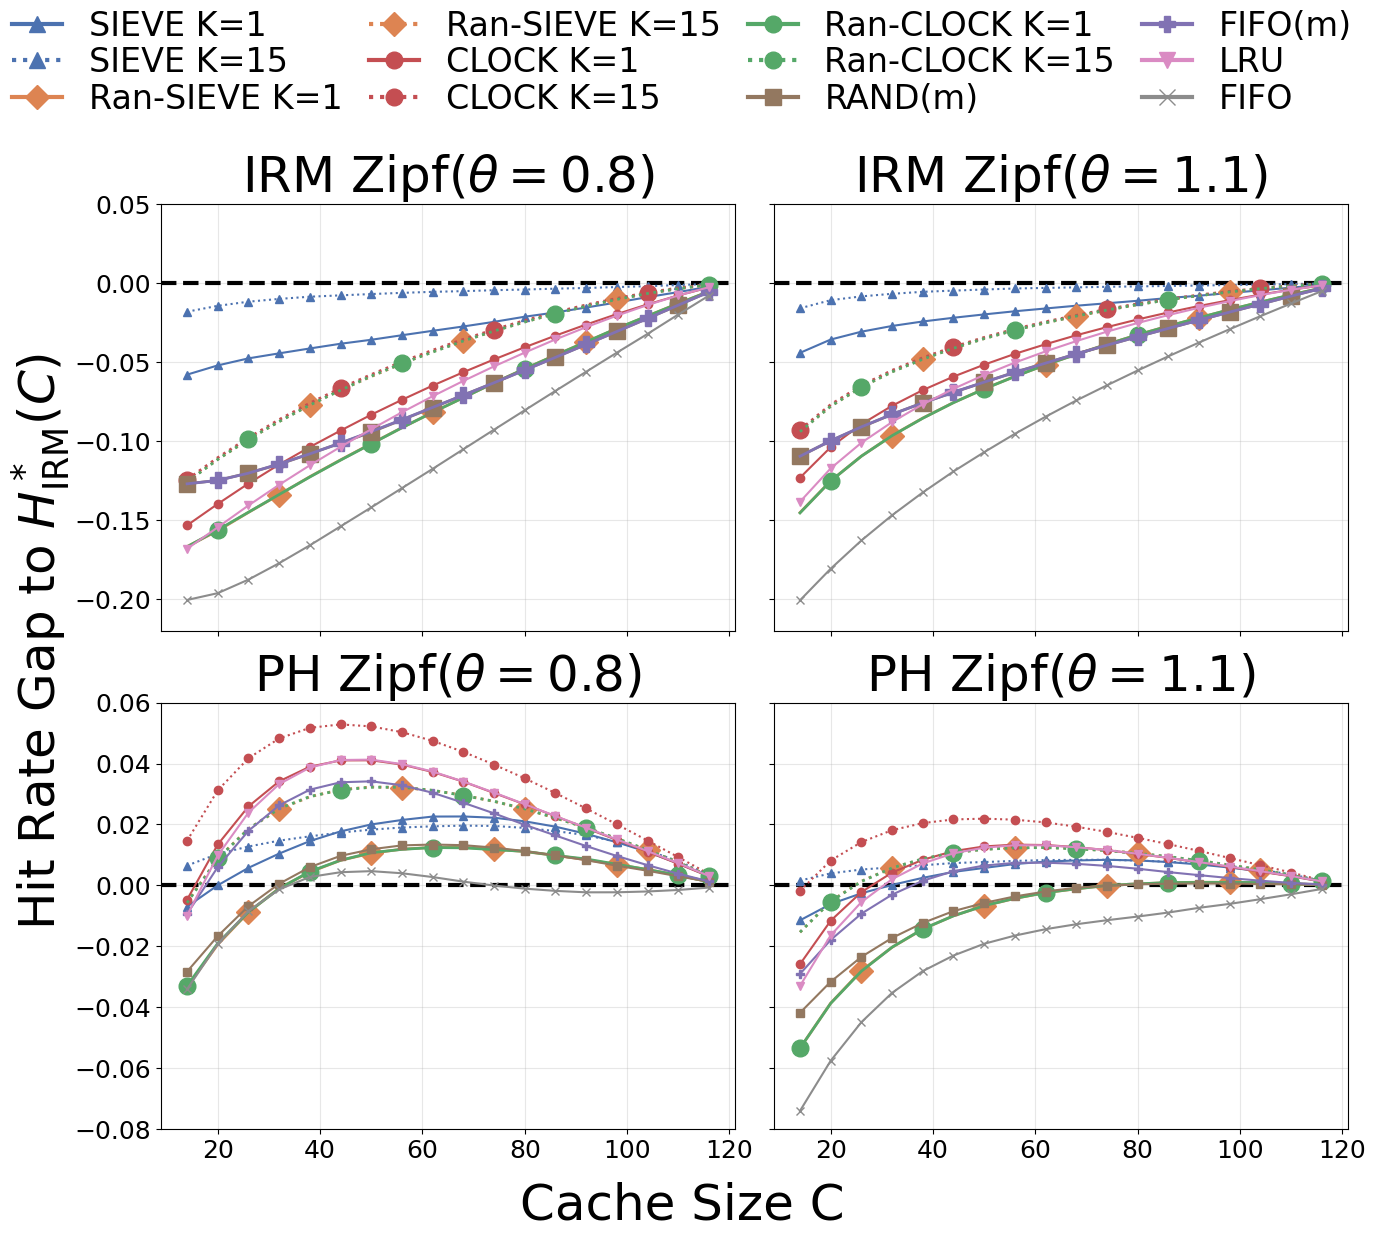

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12), sharex=True, sharey='row')
(ax_irm08_s, ax_irm11_s), (ax_ph08_s, ax_ph11_s) = axes

order_labels = [
    'SIEVE K=1',
    'SIEVE K=15',
    'Ran-SIEVE K=1',
    'Ran-SIEVE K=15',
    'CLOCK K=1',
    'CLOCK K=15',
    'Ran-CLOCK K=1',
    'Ran-CLOCK K=15',
    'RAND(m)',
    'FIFO(m)',
    'LRU',
    'FIFO',
]

lookup_irm_08 = {label: (color, marker, linestyle, c_vals) for label, color, marker, linestyle, c_vals in entries_irm_08}
lookup_irm_11 = {label: (color, marker, linestyle, c_vals) for label, color, marker, linestyle, c_vals in entries_irm_11}
lookup_ph_08 = {label: (color, marker, linestyle, c_vals) for label, color, marker, linestyle, c_vals in entries_ph_08}
lookup_ph_11 = {label: (color, marker, linestyle, c_vals) for label, color, marker, linestyle, c_vals in entries_ph_11}

irm_overlap_groups = [
    ['CLOCK K=15', 'Ran-CLOCK K=1', 'Ran-CLOCK K=15', 'Ran-SIEVE K=1', 'Ran-SIEVE K=15'],
    ['RAND(m)', 'FIFO(m)'],
]
ph_overlap_groups = [
    ['Ran-CLOCK K=1', 'Ran-CLOCK K=15', 'Ran-SIEVE K=1', 'Ran-SIEVE K=15'],
]

irm_overlap_labels = {label for group in irm_overlap_groups for label in group}
ph_overlap_labels = {label for group in ph_overlap_groups for label in group}


def build_markevery(groups):
    mapping = {}
    for group in groups:
        for idx, label in enumerate(group):
            mapping[label] = (idx, len(group))
    return mapping


def interlaced_markevery(label, c_vals, mapping):
    if label not in mapping:
        return None
    offset, step = mapping[label]
    n = len(c_vals[2:])
    return list(range(offset, n, step))


def marker_size(label, overlap_labels, base=6, large=12):
    return large if label in overlap_labels else base


def line_width(label, overlap_labels, base=1.5, bump=0.5):
    return base + bump if label in overlap_labels else base


irm_markevery = build_markevery(irm_overlap_groups)
ph_markevery = build_markevery(ph_overlap_groups)

for ax, title in [
    (ax_ph08_s, 'PH Zipf($\\theta = 0.8$)'),
    (ax_ph11_s, 'PH Zipf($\\theta = 1.1$)'),
    (ax_irm08_s, 'IRM Zipf($\\theta = 0.8$)'),
    (ax_irm11_s, 'IRM Zipf($\\theta = 1.1$)'),
]:
    ax.tick_params(axis='both', labelsize=18)
    ax.axhline(0, color='black', linestyle='--', linewidth=3)
    ax.set_title(title, fontsize=36)
    ax.grid(True)

handles_map = {}

for label in order_labels:
    if label in lookup_irm_08:
        color, marker, linestyle, c_vals = lookup_irm_08[label]
        abs_dist = dist_irm_08[label]
        markevery = interlaced_markevery(label, c_vals, irm_markevery)
        (line,) = ax_irm08_s.plot(
            c_vals[2:],
            abs_dist[2:],
            marker=marker,
            markersize=marker_size(label, irm_overlap_labels),
            label=label,
            color=color,
            linestyle=linestyle,
            linewidth=line_width(label, irm_overlap_labels),
            markevery=markevery,
        )
        handles_map.setdefault(label, line)
    if label in lookup_irm_11:
        color, marker, linestyle, c_vals = lookup_irm_11[label]
        abs_dist = dist_irm_11[label]
        markevery = interlaced_markevery(label, c_vals, irm_markevery)
        ax_irm11_s.plot(
            c_vals[2:],
            abs_dist[2:],
            marker=marker,
            markersize=marker_size(label, irm_overlap_labels),
            label=label,
            color=color,
            linestyle=linestyle,
            linewidth=line_width(label, irm_overlap_labels),
            markevery=markevery,
        )
    if label in lookup_ph_08:
        color, marker, linestyle, c_vals = lookup_ph_08[label]
        abs_dist = dist_ph_08[label]
        markevery = interlaced_markevery(label, c_vals, ph_markevery)
        (line_ph08,) = ax_ph08_s.plot(
            c_vals[2:],
            abs_dist[2:],
            marker=marker,
            markersize=marker_size(label, ph_overlap_labels),
            label=label,
            color=color,
            linestyle=linestyle,
            linewidth=line_width(label, ph_overlap_labels),
            markevery=markevery,
        )
        handles_map.setdefault(label, line_ph08)
    if label in lookup_ph_11:
        color, marker, linestyle, c_vals = lookup_ph_11[label]
        abs_dist = dist_ph_11[label]
        markevery = interlaced_markevery(label, c_vals, ph_markevery)
        (line_ph11,) = ax_ph11_s.plot(
            c_vals[2:],
            abs_dist[2:],
            marker=marker,
            markersize=marker_size(label, ph_overlap_labels),
            label=label,
            color=color,
            linestyle=linestyle,
            linewidth=line_width(label, ph_overlap_labels),
            markevery=markevery,
        )
        handles_map.setdefault(label, line_ph11)

ax_irm08_s.grid(True, alpha=0.3)
ax_irm11_s.grid(True, alpha=0.3)
ax_ph08_s.grid(True, alpha=0.3)
ax_ph11_s.grid(True, alpha=0.3)

fig.supxlabel('Cache Size C', fontsize=36)
fig.supylabel('Hit Rate Gap to $H^*_{\mathrm{IRM}}(C)$', fontsize=36)

handles = [handles_map[label] for label in order_labels if label in handles_map]
leg = fig.legend(handles, order_labels, loc='upper center', bbox_to_anchor=(0.5, 1.04), frameon=False, borderpad=0.0, labelspacing=0.1, handlelength=1.5, ncol=4, columnspacing=0.8, fontsize=24)
for line in leg.get_lines():
    line.set_linewidth(3)
    line.set_markersize(12)

irm_vals = []
for lbl in order_labels:
    for dist in (dist_irm_08, dist_irm_11):
        if lbl in dist:
            irm_vals.append(dist[lbl][2:])
irm_vals = np.concatenate(irm_vals)

y_lo = -0.22
y_hi = 0.05
ax_irm08_s.set_ylim(y_lo, y_hi)
ax_irm11_s.set_ylim(y_lo, y_hi)

ph_vals = []
for lbl in order_labels:
    for dist in (dist_ph_08, dist_ph_11):
        if lbl in dist:
            ph_vals.append(dist[lbl][2:])
ph_vals = np.concatenate(ph_vals)

y_lo = -0.08
y_hi = 0.06
ax_ph08_s.set_ylim(y_lo, y_hi)
ax_ph11_s.set_ylim(y_lo, y_hi)

fig.tight_layout(rect=[0, 0, 1, 0.92])
# fig.savefig('figures/mrcs_synths2.pdf', bbox_inches='tight', format='pdf')
plt.show()


In [33]:
w44_c_s1, w44_hr_s1, w44_c_s15, w44_hr_s15, w44_c_rs1, w44_hr_rs1, w44_c_rs15, w44_hr_rs15, w44_c_rc1, w44_hr_rc1, w44_c_rc15, w44_hr_rc15, w44_c_cc1, w44_hr_cc1, w44_c_cc15, w44_hr_cc15, w44_c_fm, w44_hr_fm, w44_c_rm, w44_hr_rm, w44_c_l, w44_hr_l, w44_c_f, w44_hr_f, w44_c_min, w44_hr_min = np.load('data/w44_mrcs.npz', allow_pickle=True).values()

# w44 = np.loadtxt('/mnt/oldssd/opt/traces/w44_r.txt', dtype=np.int32)
# w44[:, 0] += 7
# w44 = tg.squash(tg.unroll(w44 // 8))

# w44_c_s1, w44_hr_s1 = sim_sieve(w44, cnt=1)
# w44_c_s15, w44_hr_s15 = sim_sieve(w44, cnt=15)
# w44_c_rs1, w44_hr_rs1 = sim_ran_sieve(w44, cnt=1)
# w44_c_rs15, w44_hr_rs15 = sim_ran_sieve(w44, cnt=15)
# w44_c_rc1, w44_hr_rc1 = sim_ran_clock(w44, cnt=1)
# w44_c_rc15, w44_hr_rc15 = sim_ran_clock(w44, cnt=15)
# w44_c_cc1, w44_hr_cc1 = sim_clock(w44, cnt=1)
# w44_c_cc15, w44_hr_cc15 = sim_clock(w44, cnt=15)
# # w44_c_fm, w44_hr_fm = sim_fifo_m(w44)
# # w44_c_rm, w44_hr_rm = sim_rand_m(w44)
# # w44_c_l, w44_hr_l = sim_lru(w44)
# # w44_c_f, w44_hr_f = sim_fifo(w44)
# # w44_c_min, w44_hr_min = sim_min(w44)

# np.savez_compressed('data/w44_mrcs.npz',
#     c_s1=w44_c_s1, hr_s1=w44_hr_s1,
#     c_s15=w44_c_s15, hr_s15=w44_hr_s15,
#     c_rs1 = w44_c_rs1, hr_rs1 = w44_hr_rs1,
#     c_rs15 = w44_c_rs15, hr_rs15 = w44_hr_rs15,
#     c_rc1 =w44_c_rc1, hr_rc1 = w44_hr_rc1,
#     c_rc15=w44_c_rc15, hr_rc15=w44_hr_rc15,
#     c_cc1=w44_c_cc1, hr_cc1=w44_hr_cc1,
#     c_cc15=w44_c_cc15, hr_cc15=w44_hr_cc15,
#     c_fifo_m=w44_c_fm, hr_fifo_m=w44_hr_fm,
#     c_rand_m=w44_c_rm, hr_rand_m=w44_hr_rm,
#     c_lru=w44_c_l, hr_lru=w44_hr_l,
#     c_fifo=w44_c_f, hr_fifo=w44_hr_f,
#     c_min=w44_c_min, hr_min=w44_hr_min)

w11_c_s1, w11_hr_s1, w11_c_s15, w11_hr_s15, w11_c_rs1, w11_hr_rs1, w11_c_rs15, w11_hr_rs15, w11_c_rc1, w11_hr_rc1, w11_c_rc15, w11_hr_rc15, w11_c_cc1, w11_hr_cc1, w11_c_cc15, w11_hr_cc15, w11_c_fm, w11_hr_fm, w11_c_rm, w11_hr_rm, w11_c_l, w11_hr_l, w11_c_f, w11_hr_f, w11_c_min, w11_hr_min = np.load('data/w11_mrcs.npz', allow_pickle=True).values()

# w11 = np.loadtxt('/mnt/oldssd/opt/traces/w11_r.txt', dtype=np.int32)
# w11[:, 0] += 7
# w11 = tg.squash(tg.unroll(w11 // 8))

# w11_c_s1, w11_hr_s1 = sim_sieve(w11, cnt=1)
# w11_c_s15, w11_hr_s15 = sim_sieve(w11, cnt=15)
# w11_c_rs1, w11_hr_rs1 = sim_ran_sieve(w11, cnt=1)
# w11_c_rs15, w11_hr_rs15 = sim_ran_sieve(w11, cnt=15)
# w11_c_rc1, w11_hr_rc1 = sim_ran_clock(w11, cnt=1)
# w11_c_rc15, w11_hr_rc15 = sim_ran_clock(w11, cnt=15)
# w11_c_cc1, w11_hr_cc1 = sim_clock(w11, cnt=1)
# w11_c_cc15, w11_hr_cc15 = sim_clock(w11, cnt=15)
# w11_c_fm, w11_hr_fm = sim_fifo_m(w11)
# w11_c_rm, w11_hr_rm = sim_rand_m(w11)
# w11_c_l, w11_hr_l = sim_lru(w11)
# w11_c_f, w11_hr_f = sim_fifo(w11)
# w11_c_min, w11_hr_min = sim_min(w11)

# np.savez_compressed('data/w11_mrcs.npz',
#     c_s1=w11_c_s1, hr_s1=w11_hr_s1,
#     c_s15=w11_c_s15, hr_s15=w11_hr_s15,
#     c_rs1 = w11_c_rs1, hr_rs1 = w11_hr_rs1,
#     c_rs15 = w11_c_rs15, hr_rs15 = w11_hr_rs15,
#     c_rc1 =w11_c_rc1, hr_rc1 = w11_hr_rc1,
#     c_rc15=w11_c_rc15, hr_rc15=w11_hr_rc15,
#     c_cc1=w11_c_cc1, hr_cc1=w11_hr_cc1,
#     c_cc15=w11_c_cc15, hr_cc15=w11_hr_cc15,
#     c_fifo_m=w11_c_fm, hr_fifo_m=w11_hr_fm,
#     c_rand_m=w11_c_rm, hr_rand_m=w11_hr_rm,
#     c_lru=w11_c_l, hr_lru=w11_hr_l,
#     c_fifo=w11_c_f, hr_fifo=w11_hr_f,
#     c_min=w11_c_min, hr_min=w11_hr_min)

v28_c_s1, v28_hr_s1, v28_c_s15, v28_hr_s15, v28_c_rs1, v28_hr_rs1, v28_c_rs15, v28_hr_rs15, v28_c_rc1, v28_hr_rc1, v28_c_rc15, v28_hr_rc15, v28_c_cc1, v28_hr_cc1, v28_c_cc15, v28_hr_cc15, v28_c_fm, v28_hr_fm, v28_c_rm, v28_hr_rm, v28_c_l, v28_hr_l, v28_c_f, v28_hr_f, v28_c_min, v28_hr_min = np.load('data/v28_mrcs.npz', allow_pickle=True).values()

# v28 = np.loadtxt('/mnt/sda/alibaba_block_traces_2020/volume28.txt', dtype=np.int64)
# v28[:, 0] += 4095
# v28 = tg.squash(tg.unroll(v28 // 4096))

# v28_c_s1, v28_hr_s1 = sim_sieve(v28, cnt=1)
# v28_c_s15, v28_hr_s15 = sim_sieve(v28, cnt=15)
# v28_c_rs1, v28_hr_rs1 = sim_ran_sieve(v28, cnt=1)
# v28_c_rs15, v28_hr_rs15 = sim_ran_sieve(v28, cnt=15)
# v28_c_rc1, v28_hr_rc1 = sim_ran_clock(v28, cnt=1)
# v28_c_rc15, v28_hr_rc15 = sim_ran_clock(v28, cnt=15)
# v28_c_cc1, v28_hr_cc1 = sim_clock(v28, cnt=1)
# v28_c_cc15, v28_hr_cc15 = sim_clock(v28, cnt=15)
# v28_c_fm, v28_hr_fm = sim_fifo_m(v28)
# v28_c_rm, v28_hr_rm = sim_rand_m(v28)
# v28_c_l, v28_hr_l = sim_lru(v28)
# v28_c_f, v28_hr_f = sim_fifo(v28)
# v28_c_min, v28_hr_min = sim_min(v28)

# np.savez_compressed('data/v28_mrcs.npz',
#     c_s1=v28_c_s1, hr_s1=v28_hr_s1,
#     c_s15=v28_c_s15, hr_s15=v28_hr_s15,
#     c_rs1 = v28_c_rs1, hr_rs1 = v28_hr_rs1,
#     c_rs15 = v28_c_rs15, hr_rs15 = v28_hr_rs15,
#     c_rc1 =v28_c_rc1, hr_rc1 = v28_hr_rc1,
#     c_rc15=v28_c_rc15, hr_rc15=v28_hr_rc15,
#     c_cc1=v28_c_cc1, hr_cc1=v28_hr_cc1,
#     c_cc15=v28_c_cc15, hr_cc15=v28_hr_cc15,
#     c_fifo_m=v28_c_fm, hr_fifo_m=v28_hr_fm,
#     c_rand_m=v28_c_rm, hr_rand_m=v28_hr_rm,
#     c_lru=v28_c_l, hr_lru=v28_hr_l,
#     c_fifo=v28_c_f, hr_fifo=v28_hr_f,
#     c_min=v28_c_min, hr_min=v28_hr_min)

v766_c_s1, v766_hr_s1, v766_c_s15, v766_hr_s15, v766_c_rs1, v766_hr_rs1, v766_c_rs15, v766_hr_rs15, v766_c_rc1, v766_hr_rc1, v766_c_rc15, v766_hr_rc15, v766_c_cc1, v766_hr_cc1, v766_c_cc15, v766_hr_cc15, v766_c_fm, v766_hr_fm, v766_c_rm, v766_hr_rm, v766_c_l, v766_hr_l, v766_c_f, v766_hr_f, v766_c_min, v766_hr_min = np.load('data/v766_mrcs.npz', allow_pickle=True).values()

# v766 = np.loadtxt('/mnt/sda/alibaba_block_traces_2020/volume766.txt', dtype=np.int64)
# v766[:, 0] += 4095
# v766 = tg.squash(tg.unroll(v766 // 4096))

# v766_c_s1, v766_hr_s1 = sim_sieve(v766, cnt=1)
# v766_c_s15, v766_hr_s15 = sim_sieve(v766, cnt=15)
# v766_c_rs1, v766_hr_rs1 = sim_ran_sieve(v766, cnt=1)
# v766_c_rs15, v766_hr_rs15 = sim_ran_sieve(v766, cnt=15)
# v766_c_rc1, v766_hr_rc1 = sim_ran_clock(v766, cnt=1)
# v766_c_rc15, v766_hr_rc15 = sim_ran_clock(v766, cnt=15)
# v766_c_cc1, v766_hr_cc1 = sim_clock(v766, cnt=1)
# v766_c_cc15, v766_hr_cc15 = sim_clock(v766, cnt=15)
# v766_c_fm, v766_hr_fm = sim_fifo_m(v766)
# v766_c_rm, v766_hr_rm = sim_rand_m(v766)
# v766_c_l, v766_hr_l = sim_lru(v766)
# v766_c_f, v766_hr_f = sim_fifo(v766)
# v766_c_min, v766_hr_min = sim_min(v766)

# np.savez_compressed('data/v766_mrcs.npz',
#     c_s1=v766_c_s1, hr_s1=v766_hr_s1,
#     c_s15=v766_c_s15, hr_s15=v766_hr_s15,
#     c_rs1 = v766_c_rs1, hr_rs1 = v766_hr_rs1,
#     c_rs15 = v766_c_rs15, hr_rs15 = v766_hr_rs15,
#     c_rc1 =v766_c_rc1, hr_rc1 = v766_hr_rc1,
#     c_rc15=v766_c_rc15, hr_rc15=v766_hr_rc15,
#     c_cc1=v766_c_cc1, hr_cc1=v766_hr_cc1,
#     c_cc15=v766_c_cc15, hr_cc15=v766_hr_cc15,
#     c_fifo_m=v766_c_fm, hr_fifo_m=v766_hr_fm,
#     c_rand_m=v766_c_rm, hr_rand_m=v766_hr_rm,
#     c_lru=v766_c_l, hr_lru=v766_hr_l,
#     c_fifo=v766_c_f, hr_fifo=v766_hr_f,
#     c_min=v766_c_min, hr_min=v766_hr_min)


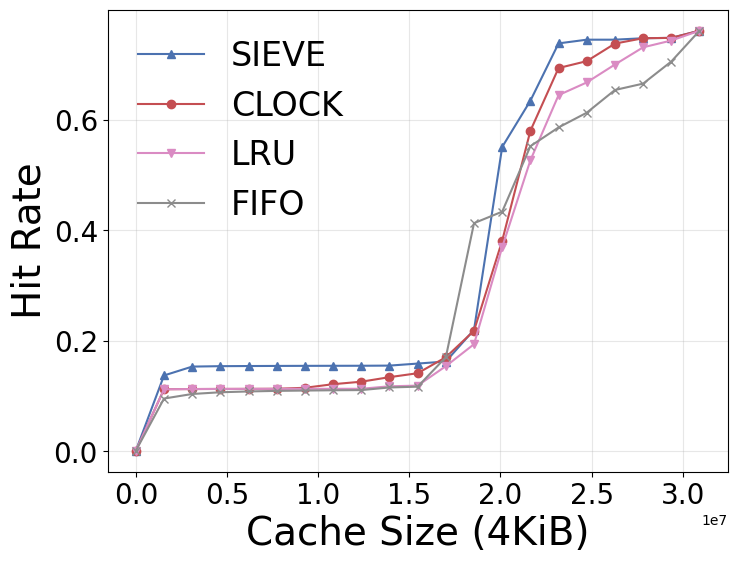

In [34]:
v28_c_s1, v28_hr_s1, v28_c_s15, v28_hr_s15, v28_c_rs1, v28_hr_rs1, v28_c_rs15, v28_hr_rs15, v28_c_rc1, v28_hr_rc1, v28_c_rc15, v28_hr_rc15, v28_c_cc1, v28_hr_cc1, v28_c_cc15, v28_hr_cc15, v28_c_fm, v28_hr_fm, v28_c_rm, v28_hr_rm, v28_c_l, v28_hr_l, v28_c_f, v28_hr_f, v28_c_min, v28_hr_min = np.load('data/v28_mrcs.npz', allow_pickle=True).values()

plt.figure(figsize=(8,6))
ax = plt.gca()
ax.tick_params(axis='both', labelsize=20)
plt.grid(True, alpha=0.3)
plt.plot(v28_c_s1, v28_hr_s1, marker='^', label='SIEVE', color=palette[0], linestyle='-', linewidth=1.5)
plt.plot(v28_c_cc1, v28_hr_cc1, marker='o', label='CLOCK', color=palette[3], linestyle='-', linewidth=1.5)
plt.plot(v28_c_l, v28_hr_l, marker='v', label='LRU', color=palette[6], linestyle='-', linewidth=1.5)
plt.plot(v28_c_f, v28_hr_f, marker='x', label='FIFO', color=palette[7], linestyle='-', linewidth=1.5)
plt.legend(fontsize=24, frameon=False)
plt.xlabel('Cache Size (4KiB)', fontsize=28)
plt.ylabel('Hit Rate', fontsize=28)
# plt.savefig('figures/mrcs_v28_sample.pdf', bbox_inches='tight', format='pdf')
plt.show()

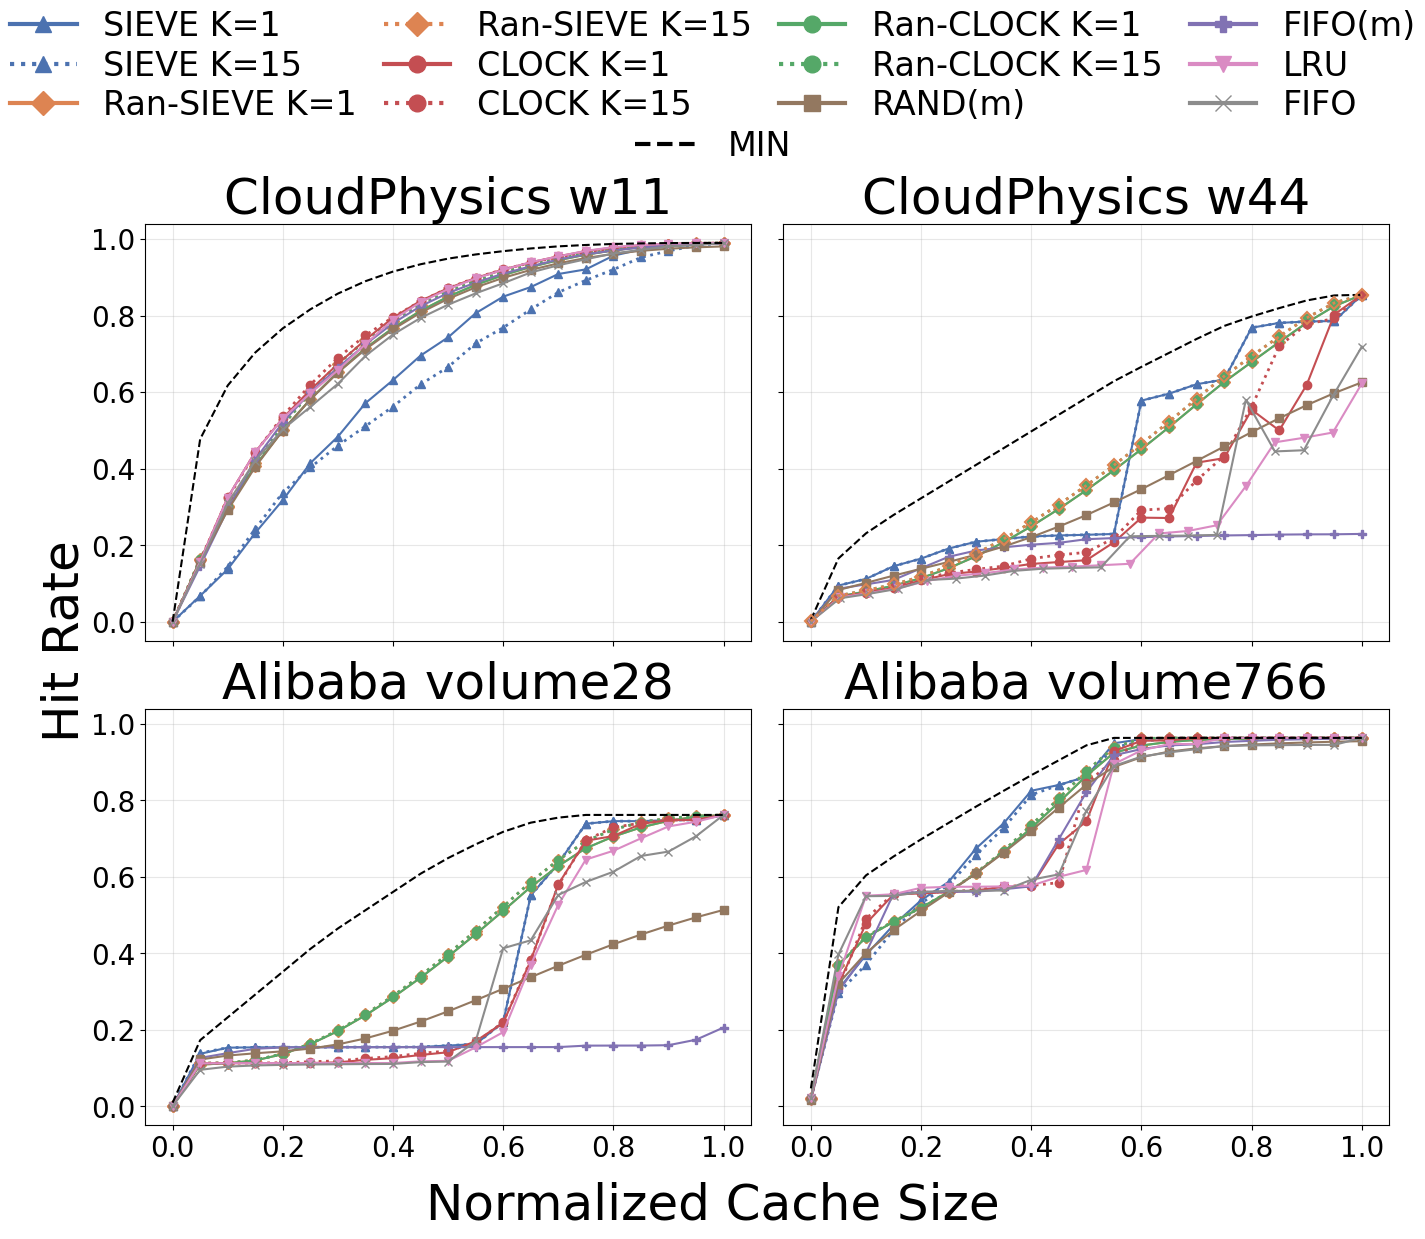

In [35]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12), sharex=True, sharey=True)
(ax_w11, ax_w44), (ax_v28, ax_v766) = axes

order_labels = [
    'SIEVE K=1',
    'SIEVE K=15',
    'Ran-SIEVE K=1',
    'Ran-SIEVE K=15',
    'CLOCK K=1',
    'CLOCK K=15',
    'Ran-CLOCK K=1',
    'Ran-CLOCK K=15',
    'RAND(m)',
    'FIFO(m)',
    'LRU',
    'FIFO',
    'MIN',
]

style_map = {
    'SIEVE': (palette[0], '^'),
    'Ran-SIEVE': (palette[1], 'D'),
    'Ran-CLOCK': (palette[2], 'o'),
    'CLOCK': (palette[3], 'o'),
    'FIFO(m)': (palette[4], 'P'),
    'RAND(m)': (palette[5], 's'),
    'LRU': (palette[6], 'v'),
    'FIFO': (palette[7], 'x'),
}

def norm_x(xs):
    xs_arr = np.asarray(xs, dtype=float)
    xmax = xs_arr.max()
    return xs_arr / xmax if xmax != 0 else xs_arr

data_sets = [
    (ax_w11, 'CloudPhysics w11', [
        ('SIEVE K=1', w11_c_s1, w11_hr_s1),
        ('SIEVE K=15', w11_c_s15, w11_hr_s15),
        ('Ran-SIEVE K=1', w11_c_rs1, w11_hr_rs1),
        ('Ran-SIEVE K=15', w11_c_rs15, w11_hr_rs15),
        ('Ran-CLOCK K=1', w11_c_rc1, w11_hr_rc1),
        ('Ran-CLOCK K=15', w11_c_rc15, w11_hr_rc15),
        ('CLOCK K=1', w11_c_cc1, w11_hr_cc1),
        ('CLOCK K=15', w11_c_cc15, w11_hr_cc15),
        ('FIFO(m)', w11_c_fm, w11_hr_fm),
        ('RAND(m)', w11_c_rm, w11_hr_rm),
        ('LRU', w11_c_l, w11_hr_l),
        ('FIFO', w11_c_f, w11_hr_f),
        ('MIN', w11_c_min, w11_hr_min),
    ]),
    (ax_w44, 'CloudPhysics w44', [
        ('SIEVE K=1', w44_c_s1, w44_hr_s1),
        ('SIEVE K=15', w44_c_s15, w44_hr_s15),
        ('Ran-SIEVE K=1', w44_c_rs1, w44_hr_rs1),
        ('Ran-SIEVE K=15', w44_c_rs15, w44_hr_rs15),
        ('Ran-CLOCK K=1', w44_c_rc1, w44_hr_rc1),
        ('Ran-CLOCK K=15', w44_c_rc15, w44_hr_rc15),
        ('CLOCK K=1', w44_c_cc1, w44_hr_cc1),
        ('CLOCK K=15', w44_c_cc15, w44_hr_cc15),
        ('FIFO(m)', w44_c_fm, w44_hr_fm),
        ('RAND(m)', w44_c_rm, w44_hr_rm),
        ('LRU', w44_c_l, w44_hr_l),
        ('FIFO', w44_c_f, w44_hr_f),
        ('MIN', w44_c_min, w44_hr_min),
    ]),
    (ax_v28, 'Alibaba volume28', [
        ('SIEVE K=1', v28_c_s1, v28_hr_s1),
        ('SIEVE K=15', v28_c_s15, v28_hr_s15),
        ('Ran-SIEVE K=1', v28_c_rs1, v28_hr_rs1),
        ('Ran-SIEVE K=15', v28_c_rs15, v28_hr_rs15),
        ('Ran-CLOCK K=1', v28_c_rc1, v28_hr_rc1),
        ('Ran-CLOCK K=15', v28_c_rc15, v28_hr_rc15),
        ('CLOCK K=1', v28_c_cc1, v28_hr_cc1),
        ('CLOCK K=15', v28_c_cc15, v28_hr_cc15),
        ('FIFO(m)', v28_c_fm, v28_hr_fm),
        ('RAND(m)', v28_c_rm, v28_hr_rm),
        ('LRU', v28_c_l, v28_hr_l),
        ('FIFO', v28_c_f, v28_hr_f),
        ('MIN', v28_c_min, v28_hr_min),
    ]),
    (ax_v766, 'Alibaba volume766', [
        ('SIEVE K=1', v766_c_s1, v766_hr_s1),
        ('SIEVE K=15', v766_c_s15, v766_hr_s15),
        ('Ran-SIEVE K=1', v766_c_rs1, v766_hr_rs1),
        ('Ran-SIEVE K=15', v766_c_rs15, v766_hr_rs15),
        ('Ran-CLOCK K=1', v766_c_rc1, v766_hr_rc1),
        ('Ran-CLOCK K=15', v766_c_rc15, v766_hr_rc15),
        ('CLOCK K=1', v766_c_cc1, v766_hr_cc1),
        ('CLOCK K=15', v766_c_cc15, v766_hr_cc15),
        ('FIFO(m)', v766_c_fm, v766_hr_fm),
        ('RAND(m)', v766_c_rm, v766_hr_rm),
        ('LRU', v766_c_l, v766_hr_l),
        ('FIFO', v766_c_f, v766_hr_f),
        ('MIN', v766_c_min, v766_hr_min),
    ]),
]

handles_map = {}
for ax, title, series in data_sets:
    ax.tick_params(axis='both', labelsize=20)
    ax.grid(True, alpha=0.3)
    ax.set_title(title, fontsize=36)
    for label, xs, ys in series:
        base = label.split(' K=')[0]
        if base == 'MIN':
            color, marker, linestyle, linewidth = 'black', None, '--', 1.5
        else:
            color, marker = style_map[base]
            linestyle = ':' if 'K=15' in label else '-'
            linewidth = 2 if 'K=15' in label else 1.5

        plot_kwargs = {}
        if label == 'Ran-SIEVE K=15' and 'w44' in title.lower():
            plot_kwargs.update(zorder=5, markerfacecolor='none', markeredgewidth=1.5)

        xs_norm = norm_x(xs)
        ax.plot(
            xs_norm,
            ys,
            marker=marker,
            label=label,
            color=color,
            linestyle=linestyle,
            linewidth=linewidth,
            **plot_kwargs,
        )
        if label not in handles_map:
            (h,) = ax.plot(
                [],
                [],
                marker=marker,
                color=color,
                linestyle=linestyle,
                linewidth=linewidth if base == 'MIN' else 1.5,
                label=label,
                **plot_kwargs,
            )
            handles_map[label] = h

fig.supxlabel('Normalized Cache Size', fontsize=36)
fig.supylabel('Hit Rate', fontsize=36)

main_labels = [lbl for lbl in order_labels if lbl != 'MIN']
handles_main = [handles_map[label] for label in main_labels]
leg_main = fig.legend(
    handles_main,
    main_labels,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.04),
    frameon=False,
    borderpad=0.0,
    labelspacing=0.2,
    handlelength=2.0,
    ncol=4,
    columnspacing=0.8,
    fontsize=24,
)
leg_min = fig.legend(
    [handles_map['MIN']],
    ['MIN'],
    loc='upper center',
    bbox_to_anchor=(0.5, 0.94),
    frameon=False,
    borderpad=0.0,
    labelspacing=0.2,
    handlelength=2.0,
    ncol=1,
    columnspacing=0.8,
    fontsize=24,
)
for leg in (leg_main, leg_min):
    for line in leg.get_lines():
        line.set_linewidth(3)
        line.set_markersize(12)

fig.tight_layout(rect=[0, 0, 1, 0.9])
# fig.savefig('figures/mrcs_real.pdf', bbox_inches='tight', format='pdf')
plt.show()


In [36]:
avgs_w11 = [(name, _, np.mean(hr)) for name, _, hr in data_sets[0][2]]
avgs_w11.sort(key=lambda x: x[2], reverse=True)
avgs_w44 = [(name, _, np.mean(hr)) for name, _, hr in data_sets[1][2]]
avgs_w44.sort(key=lambda x: x[2], reverse=True)
avgs_v28 = [(name, _, np.mean(hr)) for name, _, hr in data_sets[2][2]]
avgs_v28.sort(key=lambda x: x[2], reverse=True)
avgs_v766 = [(name, _, np.mean(hr)) for name, _, hr in data_sets[3][2]]
avgs_v766.sort(key=lambda x: x[2], reverse=True)

print("Average Hit Rates:")
for name, _, avg in avgs_w11:
    print(f"w11 {name}: {avg:.6f}")
print()
for name, _, avg in avgs_w44:
    print(f"w44 {name}: {avg:.6f}")
print()
for name, _, avg in avgs_v28:
    print(f"v28 {name}: {avg:.6f}") 
print()
for name, _, avg in avgs_v766:
    print(f"v766 {name}: {avg:.6f}")   

Average Hit Rates:
w11 MIN: 0.844873
w11 CLOCK K=15: 0.743842
w11 CLOCK K=1: 0.742469
w11 LRU: 0.740031
w11 Ran-CLOCK K=15: 0.735405
w11 Ran-SIEVE K=15: 0.735399
w11 FIFO(m): 0.732175
w11 Ran-CLOCK K=1: 0.727485
w11 Ran-SIEVE K=1: 0.727481
w11 RAND(m): 0.721678
w11 FIFO: 0.717234
w11 SIEVE K=1: 0.644792
w11 SIEVE K=15: 0.613981

w44 MIN: 0.549101
w44 SIEVE K=1: 0.401969
w44 SIEVE K=15: 0.401969
w44 Ran-SIEVE K=15: 0.398659
w44 Ran-CLOCK K=15: 0.398656
w44 Ran-CLOCK K=1: 0.389621
w44 Ran-SIEVE K=1: 0.389621
w44 CLOCK K=15: 0.314025
w44 RAND(m): 0.307527
w44 CLOCK K=1: 0.291756
w44 FIFO: 0.240018
w44 LRU: 0.222171
w44 FIFO(m): 0.183867

v28 MIN: 0.558615
v28 Ran-SIEVE K=15: 0.417030
v28 Ran-CLOCK K=15: 0.417028
v28 Ran-CLOCK K=1: 0.410633
v28 Ran-SIEVE K=1: 0.410631
v28 SIEVE K=15: 0.361435
v28 SIEVE K=1: 0.361344
v28 CLOCK K=15: 0.333132
v28 CLOCK K=1: 0.330930
v28 FIFO: 0.316414
v28 LRU: 0.315947
v28 RAND(m): 0.273025
v28 FIFO(m): 0.149186

v766 MIN: 0.819585
v766 SIEVE K=1: 0.755786
v

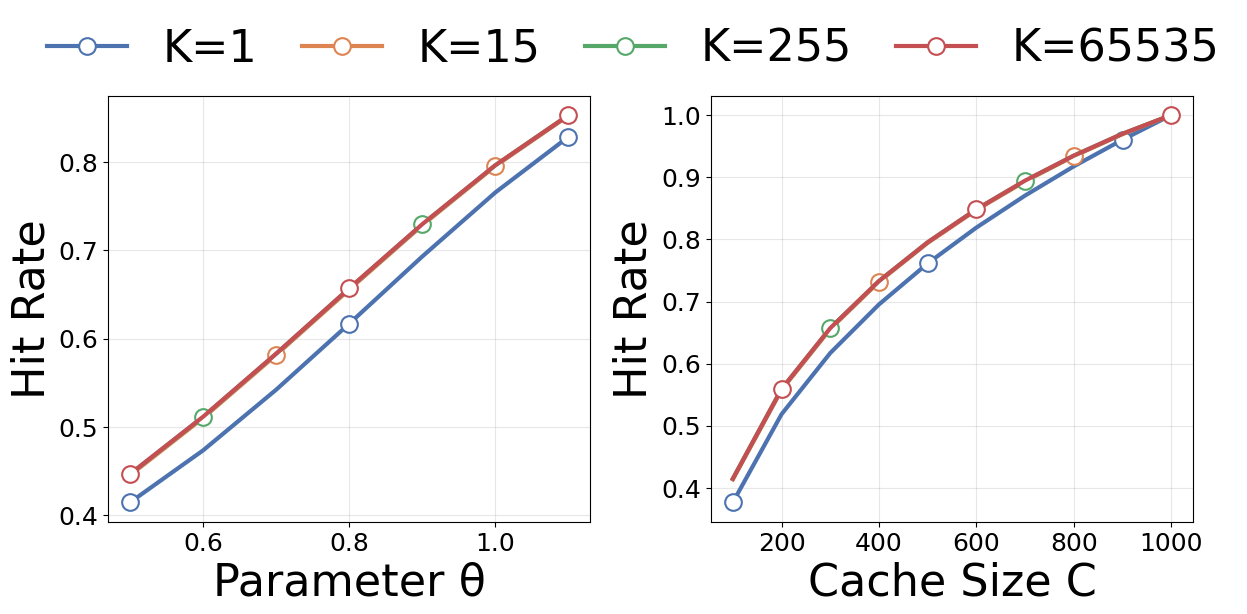

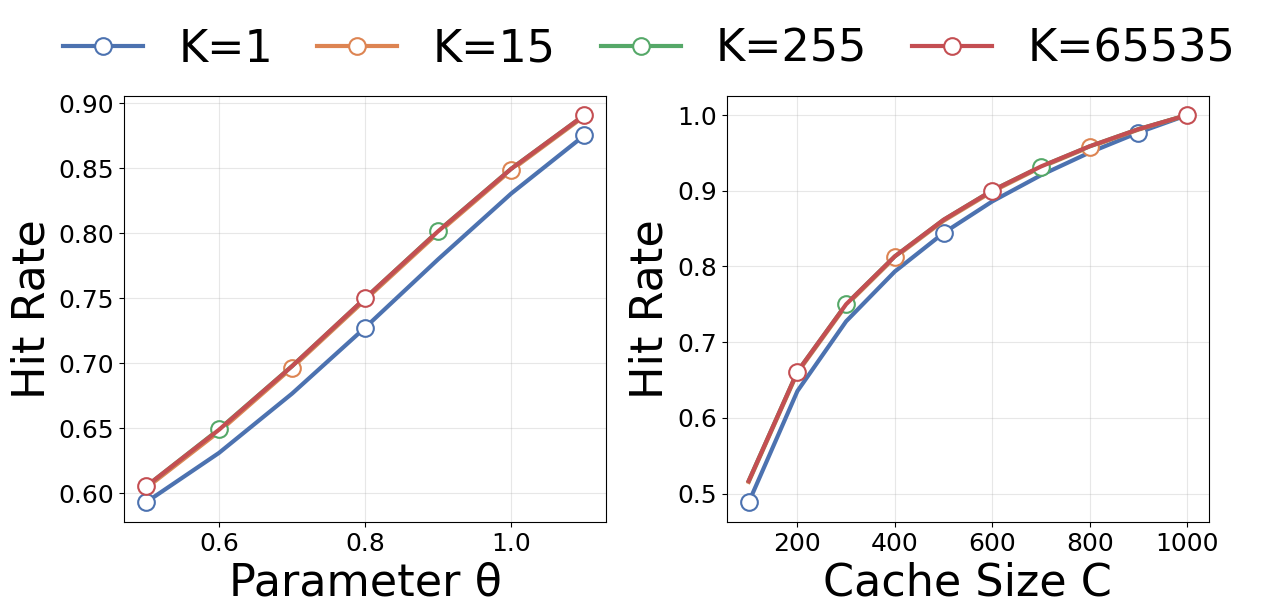

In [42]:
ks = [1, 15, 255, 65535]
thetas = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1]
cache_sizes = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
trace_len = 10_000_000
n_items = 1000
base_theta = 0.8
base_theta_idx = thetas.index(base_theta)

irm_traces = [gen_from_zipf(n_items, trace_len, theta)[1].astype(np.int32) for theta in thetas]
ph_traces = [gen_ph_2class(n_items, theta, trace_len).astype(np.int32) for theta in thetas]

run_rc = lambda C, trc, K: tg.sim_ran_clock(C, trc, raw=True, K=K)

C_theta = 300
hr_vs_theta_irm = {k: [run_rc(C_theta, trc, k) for trc in irm_traces] for k in ks}
hr_vs_theta_ph = {k: [run_rc(C_theta, trc, k) for trc in ph_traces] for k in ks}

irm_base = irm_traces[base_theta_idx]
ph_base = ph_traces[base_theta_idx]
hr_vs_C_irm = {k: [run_rc(C, irm_base, k) for C in cache_sizes] for k in ks}
hr_vs_C_ph = {k: [run_rc(C, ph_base, k) for C in cache_sizes] for k in ks}


colors = sns.color_palette("deep", len(ks))

theta_marker_positions = {}
cache_marker_positions = {}
for idx, k in enumerate(ks):
    theta_pos = [i for i in range(len(thetas)) if (i + idx) % 3 == 0]
    cache_pos = [i for i in range(len(cache_sizes)) if (i + idx) % 4 == 0]
    theta_marker_positions[k] = theta_pos or [0]
    cache_marker_positions[k] = cache_pos or [0]


def plot_family(title_prefix, hr_theta, hr_cache, outfile):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)
    handles = []
    labels = []
    for k, color in zip(ks, colors):
        theta_marks = theta_marker_positions[k]
        cache_marks = cache_marker_positions[k]

        [line] = axes[0].plot(
            thetas,
            hr_theta[k],
            lw=3.0,
            color=color,
            linestyle="-",
            marker="o",
            markersize=12,
            markerfacecolor="white",
            markeredgecolor=color,
            markeredgewidth=1.5,
            markevery=theta_marks,
            label=None,
        )
        axes[1].plot(
            cache_sizes,
            hr_cache[k],
            lw=3.0,
            color=color,
            linestyle="-",
            marker="o",
            markersize=12,
            markerfacecolor="white",
            markeredgecolor=color,
            markeredgewidth=1.5,
            markevery=cache_marks,
            label=None,
        )
        handles.append(line)
        labels.append(f"K={k}")

    axes[0].set_xlabel("Parameter θ", fontsize=32)
    axes[0].set_ylabel("Hit Rate", fontsize=32)
    axes[0].tick_params(axis="both", labelsize=18)
    axes[0].grid(True, alpha=0.3)

    axes[1].set_xlabel("Cache Size C", fontsize=32)
    axes[1].set_ylabel("Hit Rate", fontsize=32)
    axes[1].tick_params(axis="both", labelsize=18)
    axes[1].grid(True, alpha=0.3)

    fig.legend(
        handles,
        labels,
        loc="upper center",
        bbox_to_anchor=(0.5, 1),
        ncol=len(labels),
        fontsize=32,
        frameon=False,
        handlelength=1.8,
        columnspacing=1.0,
    )
    fig.subplots_adjust(top=0.82, wspace=0.25)
    plt.savefig(outfile, bbox_inches='tight', format='pdf')
    plt.show()

plot_family("IRM", hr_vs_theta_irm, hr_vs_C_irm, 'figures/rc_k_irm.pdf')
plot_family("PH", hr_vs_theta_ph, hr_vs_C_ph, 'figures/rc_k_ph.pdf')

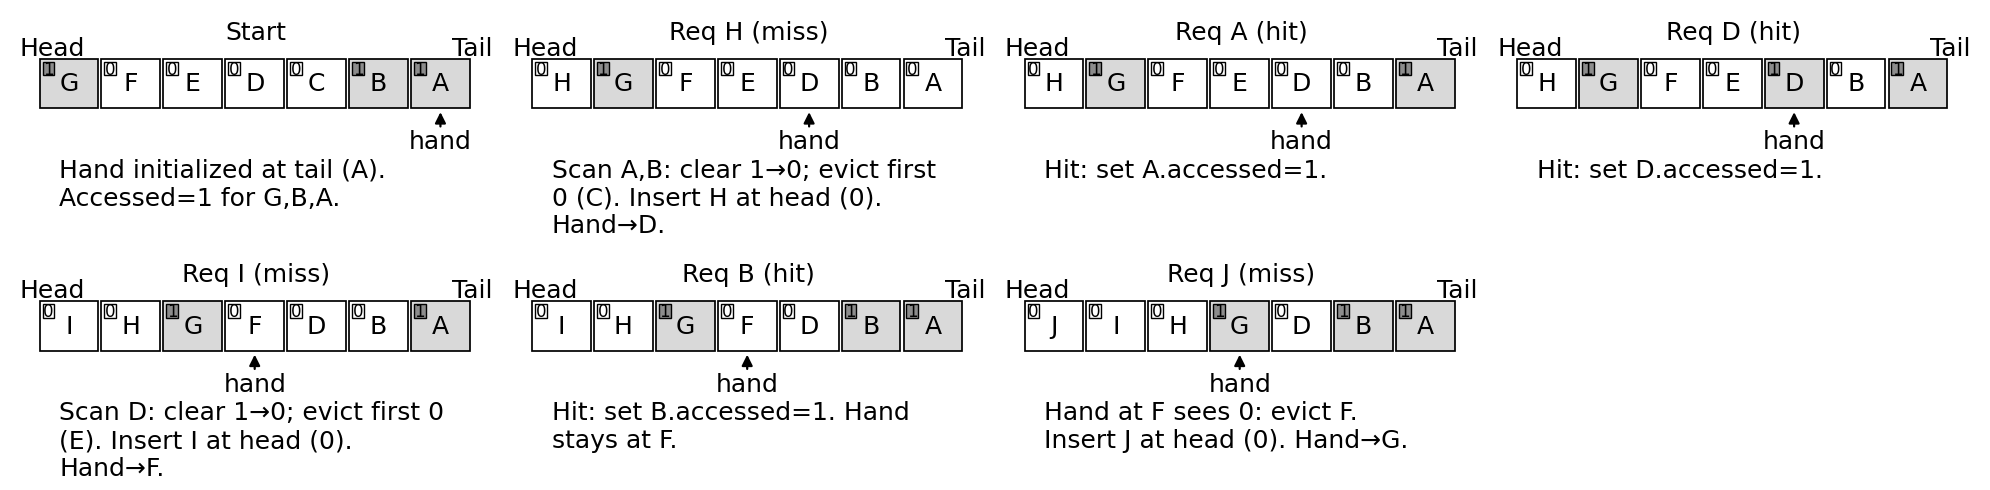

In [43]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrowPatch

panels = [
    {"title":"Start","queue":list("GFEDCBA"),"visited_ones":{"G","B","A"},"hand":"A",
     "note":"Hand initialized at tail (A). Accessed=1 for G,B,A."},
    {"title":"Req H (miss)","queue":list("HGFEDBA"),"visited_ones":{"G"},"hand":"D",
     "note":"Scan A,B: clear 1→0; evict first 0 (C). Insert H at head (0). Hand→D."},
    {"title":"Req A (hit)","queue":list("HGFEDBA"),"visited_ones":{"G","A"},"hand":"D",
     "note":"Hit: set A.accessed=1."},
    {"title":"Req D (hit)","queue":list("HGFEDBA"),"visited_ones":{"G","A","D"},"hand":"D",
     "note":"Hit: set D.accessed=1."},
    {"title":"Req I (miss)","queue":list("IHGFDBA"),"visited_ones":{"G","A"},"hand":"F",
     "note":"Scan D: clear 1→0; evict first 0 (E). Insert I at head (0). Hand→F."},
     {"title":"Req B (hit)","queue":list("IHGFDBA"),"visited_ones":{"G","A","B"},"hand":"F",
 "note":"Hit: set B.accessed=1. Hand stays at F."},
    {"title":"Req J (miss)","queue":list("JIHGDBA"),"visited_ones":{"G","A","B"},"hand":"G",
     "note":"Hand at F sees 0: evict F. Insert J at head (0). Hand→G."},
]

FS_TITLE = 18
FS_HEADTAIL = 18
FS_ITEM = 18
FS_BIT = 12
FS_HAND = 18
FS_NOTE = 18
FS_SCAN = 13

def draw_queue(ax, queue, visited_ones, hand_item):
    ax.set_axis_off()
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 3)

    ax.text(0.2, 2.3, "Head", fontsize=FS_HEADTAIL, ha="left", va="center")
    ax.text(9.8, 2.3, "Tail", fontsize=FS_HEADTAIL, ha="right", va="center")

    n = len(queue)
    x0, y0 = 0.6, 1.2
    W, H = 8.8 / n, 0.9

    for i, item in enumerate(queue):
        x = x0 + i * W
        v = 1 if item in visited_ones else 0
        face = "0.85" if v == 1 else "white"

        rect = Rectangle((x, y0), W * 0.95, H, linewidth=1.25, edgecolor="black", facecolor=face)
        ax.add_patch(rect)
        ax.text(x + (W * 0.95) / 2, y0 + H / 2, item, fontsize=FS_ITEM, ha="center", va="center")

        bit_size = min(W * 0.25, 0.24)
        bit_face = "0.55" if v == 1 else "white"
        bit = Rectangle((x + 0.06, y0 + H - bit_size - 0.06), bit_size, bit_size,
                        linewidth=1.0, edgecolor="black", facecolor=bit_face)
        ax.add_patch(bit)
        ax.text(x + 0.06 + bit_size / 2, y0 + H - bit_size / 2 - 0.06, str(v),
                fontsize=FS_BIT, ha="center", va="center")

        if item == hand_item:
            arrow = FancyArrowPatch((x + (W * 0.95) / 2, y0 - 0.38),
                                    (x + (W * 0.95) / 2, y0 - 0.02),
                                    arrowstyle='-|>', mutation_scale=16,
                                    linewidth=1.6, color="black")
            ax.add_patch(arrow)
            ax.text(x + (W * 0.95) / 2, y0 - 0.38, "hand", fontsize=FS_HAND, ha="center", va="top")

    # ax.annotate("scan direction", xy=(8.9, 0.52), xytext=(1.2, 0.52),
    #             arrowprops=dict(arrowstyle="<-", linewidth=1.4),
    #             fontsize=FS_SCAN, ha="left", va="center")



fig = plt.figure(figsize=(20, 5))
gs = fig.add_gridspec(2, 4, wspace=0)
axes = [fig.add_subplot(gs[i]) for i in range(7)]

import textwrap

for ax, p in zip(axes, panels):
    ax.set_title(p["title"], fontsize=FS_TITLE, y=0.82, pad=0)
    draw_queue(ax, p["queue"], p["visited_ones"], p["hand"])
    note = textwrap.fill(p["note"], width=32)
    ax.text(0.1, 0.1, note, transform=ax.transAxes,
            fontsize=FS_NOTE, ha="left", va="top")


plt.tight_layout()
# fig.savefig("sieve_example_static_diagram_bigfont.png", dpi=220, bbox_inches="tight")
# fig.savefig("sieve_example_static_diagram_bigfont.svg", bbox_inches="tight")
fig.savefig("figures/sieve_example_diagram.pdf", bbox_inches="tight", format='pdf')
plt.show()
plt.close(fig)


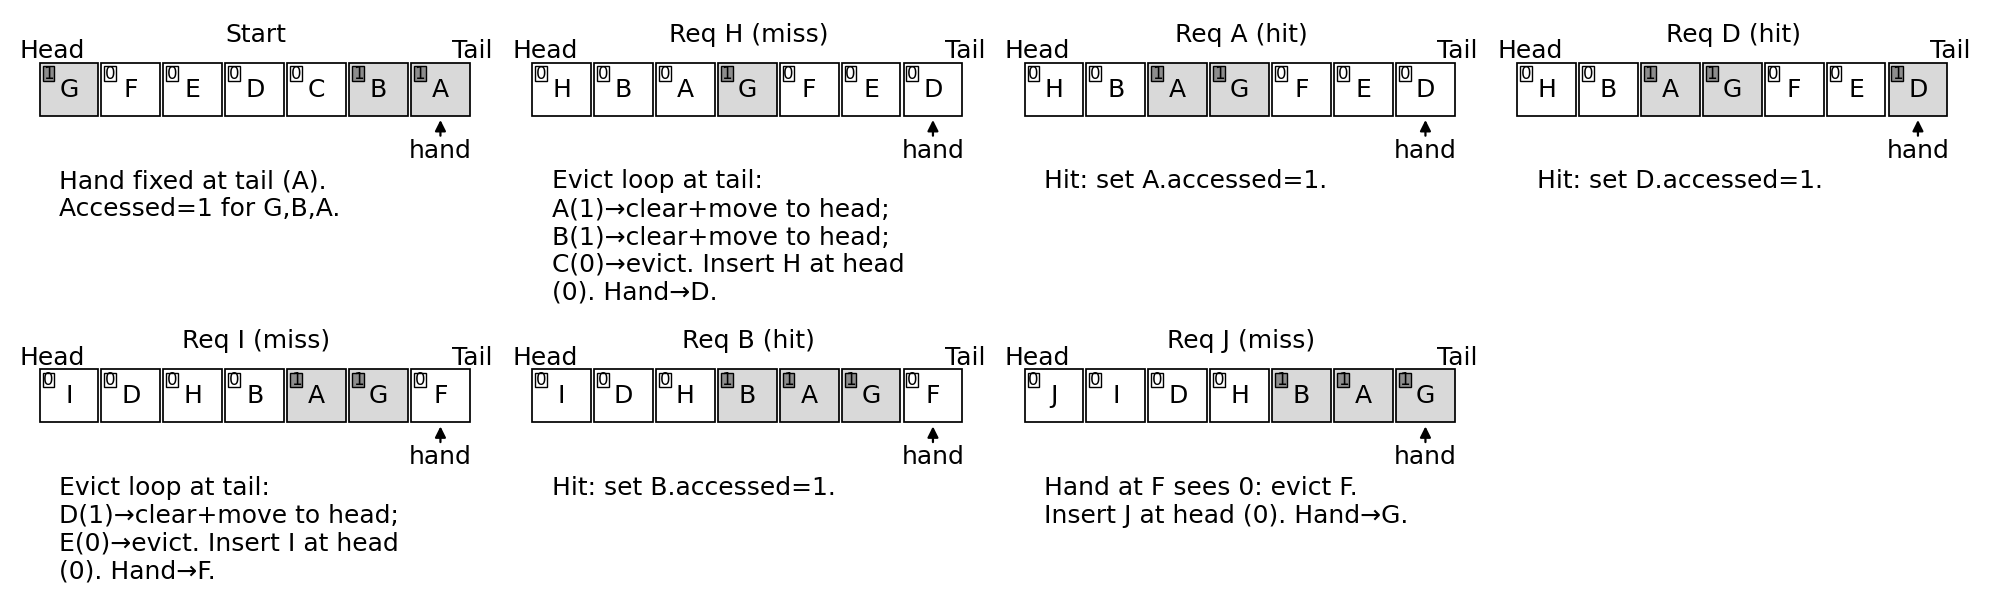

In [44]:

panels = [
    {"title":"Start","queue":list("GFEDCBA"),"visited_ones":{"G","B","A"},"hand":"A",
     "note":"Hand fixed at tail (A). Accessed=1 for G,B,A."},

    {"title":"Req H (miss)","queue":list("HBAGFED"),"visited_ones":{"G"},"hand":"D",
     "note":"Evict loop at tail: A(1)→clear+move to head; B(1)→clear+move to head; C(0)→evict. Insert H at head (0). Hand→D."},

    {"title":"Req A (hit)","queue":list("HBAGFED"),"visited_ones":{"G","A"},"hand":"D",
     "note":"Hit: set A.accessed=1."},

    {"title":"Req D (hit)","queue":list("HBAGFED"),"visited_ones":{"G","A","D"},"hand":"D",
     "note":"Hit: set D.accessed=1."},

    {"title":"Req I (miss)","queue":list("IDHBAGF"),"visited_ones":{"G","A"},"hand":"F",
     "note":"Evict loop at tail: D(1)→clear+move to head; E(0)→evict. Insert I at head (0). Hand→F."},

    {"title":"Req B (hit)","queue":list("IDHBAGF"),"visited_ones":{"G","A","B"},"hand":"F",
     "note":"Hit: set B.accessed=1."},

    {"title":"Req J (miss)","queue":list("JIDHBAG"),"visited_ones":{"G","A","B"},"hand":"G",
     "note":"Hand at F sees 0: evict F. Insert J at head (0). Hand→G."},
]

FS_TITLE = 18
FS_HEADTAIL = 18
FS_ITEM = 18
FS_BIT = 12
FS_HAND = 18
FS_NOTE = 18
FS_SCAN = 13

def draw_queue(ax, queue, visited_ones, hand_item):
    ax.set_axis_off()
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 3)

    ax.text(0.2, 2.3, "Head", fontsize=FS_HEADTAIL, ha="left", va="center")
    ax.text(9.8, 2.3, "Tail", fontsize=FS_HEADTAIL, ha="right", va="center")

    n = len(queue)
    x0, y0 = 0.6, 1.2
    W, H = 8.8 / n, 0.9

    for i, item in enumerate(queue):
        x = x0 + i * W
        v = 1 if item in visited_ones else 0
        face = "0.85" if v == 1 else "white"

        rect = Rectangle((x, y0), W * 0.95, H, linewidth=1.25, edgecolor="black", facecolor=face)
        ax.add_patch(rect)
        ax.text(x + (W * 0.95) / 2, y0 + H / 2, item, fontsize=FS_ITEM, ha="center", va="center")

        bit_size = min(W * 0.25, 0.24)
        bit_face = "0.55" if v == 1 else "white"
        bit = Rectangle((x + 0.06, y0 + H - bit_size - 0.06), bit_size, bit_size,
                        linewidth=1.0, edgecolor="black", facecolor=bit_face)
        ax.add_patch(bit)
        ax.text(x + 0.06 + bit_size / 2, y0 + H - bit_size / 2 - 0.06, str(v),
                fontsize=FS_BIT, ha="center", va="center")

        if item == hand_item:
            arrow = FancyArrowPatch((x + (W * 0.95) / 2, y0 - 0.38),
                                    (x + (W * 0.95) / 2, y0 - 0.02),
                                    arrowstyle='-|>', mutation_scale=16,
                                    linewidth=1.6, color="black")
            ax.add_patch(arrow)
            ax.text(x + (W * 0.95) / 2, y0 - 0.38, "hand", fontsize=FS_HAND, ha="center", va="top")

    # ax.annotate("scan direction", xy=(8.9, 0.52), xytext=(1.2, 0.52),
    #             arrowprops=dict(arrowstyle="<-", linewidth=1.4),
    #             fontsize=FS_SCAN, ha="left", va="center")



fig = plt.figure(figsize=(20, 6))
gs = fig.add_gridspec(2, 4, wspace=0)
axes = [fig.add_subplot(gs[i]) for i in range(7)]

import textwrap

for ax, p in zip(axes, panels):
    ax.set_title(p["title"], fontsize=FS_TITLE, y=0.82, pad=0)
    draw_queue(ax, p["queue"], p["visited_ones"], p["hand"])
    note = textwrap.fill(p["note"], width=32)
    ax.text(0.1, 0.1, note, transform=ax.transAxes,
            fontsize=FS_NOTE, ha="left", va="top")


plt.tight_layout()
# fig.savefig("sieve_example_static_diagram_bigfont.png", dpi=220, bbox_inches="tight")
# fig.savefig("sieve_example_static_diagram_bigfont.svg", bbox_inches="tight")
fig.savefig("figures/clock_example_diagram.pdf", bbox_inches="tight", format='pdf')
plt.show()
plt.close(fig)


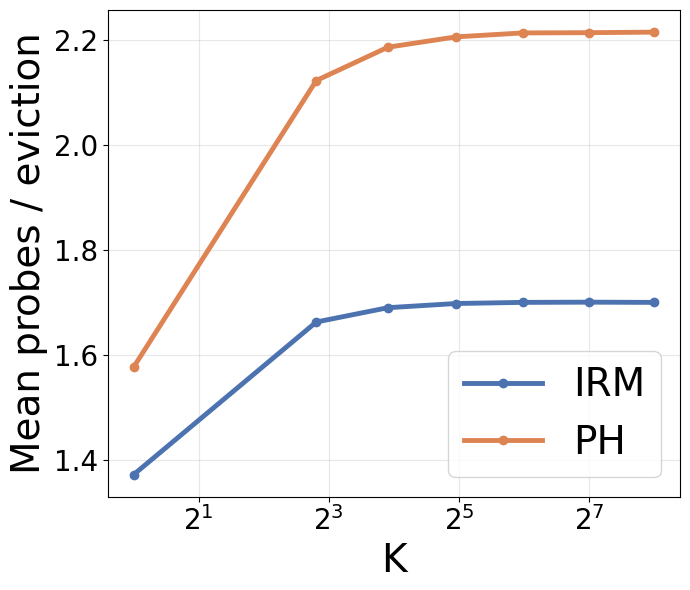

In [25]:

ks = [1, 7, 15, 31, 63, 127, 255]
mean_irm = np.empty(len(ks), dtype=float)
mean_ph = np.empty(len(ks), dtype=float)

for i, k in enumerate(ks):
    rc = tg.ran_clock(C=24, K=k)
    _, _, examined_irm_k, _ = rc.run_age(irm_08)
    _, _, examined_ph_k, _ = rc.run_age(ph_08)

    arr_irm = np.asarray(examined_irm_k, dtype=float)
    arr_ph = np.asarray(examined_ph_k, dtype=float)
    nz_irm = arr_irm > 0 
    nz_ph = arr_ph > 0

    mean_irm[i] = arr_irm[nz_irm].mean() if nz_irm.any() else 0.0
    mean_ph[i] = arr_ph[nz_ph].mean() if nz_ph.any() else 0.0

fig, ax = plt.subplots(figsize=(7, 6))
ax.plot(ks, mean_irm, marker='o', markersize=6, lw=3.5, label='IRM')
ax.plot(ks, mean_ph, marker='o', markersize=6, lw=3.5, label='PH')
ax.set_xscale("log", base=2)
ax.set_xlabel("K", fontsize=28)
ax.set_ylabel("Mean probes / eviction", fontsize=28)
ax.tick_params(axis="both", labelsize=20)
ax.legend(fontsize=28)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("figures/mean_probes.pdf", bbox_inches="tight")
plt.show()


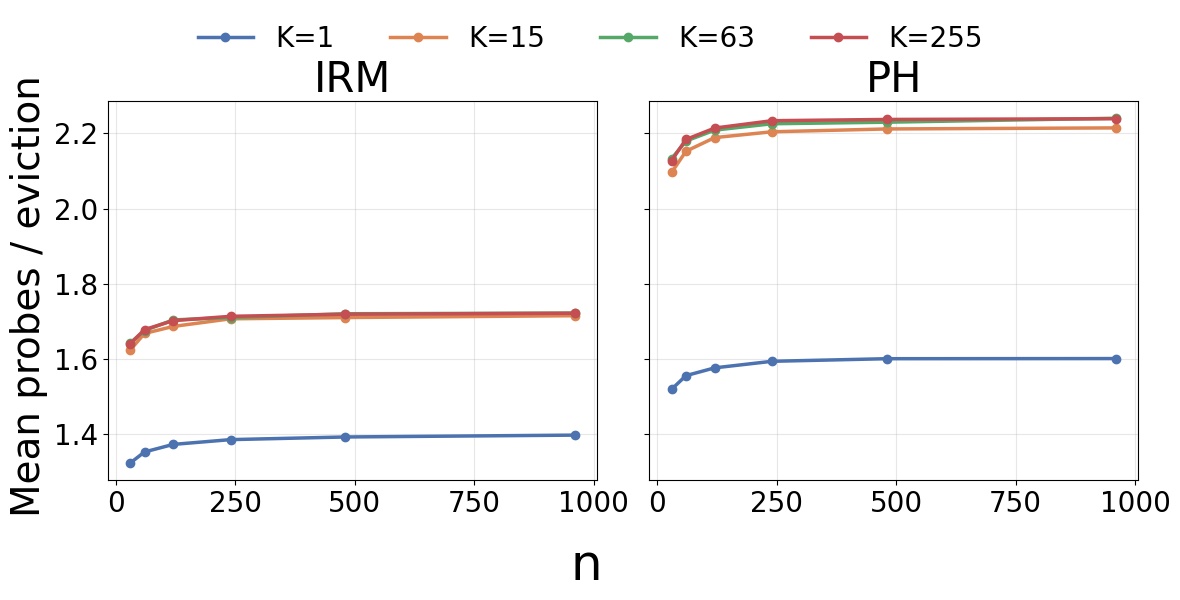

In [21]:

k_values = [1, 15, 63, 255]
ns = [30, 60, 120, 240, 480, 960]

means_irm = np.zeros((len(k_values), len(ns)), dtype=float)
means_ph = np.zeros_like(means_irm)

for ki, k in enumerate(k_values):
    for ci, n in enumerate(ns):
        trace_irm = gen_from_zipf(n, 1_000_000, 0.8)[1].astype(np.int32)
        trace_ph = gen_ph_2class(n, 0.8, 1_000_000, mu_ratio=10.0).astype(np.int32)
        c = max(1, n // 5)
        rc = tg.ran_clock(C=c, K=k)
        _, _, examined_irm_k, _ = rc.run_age(trace_irm)
        _, _, examined_ph_k, _ = rc.run_age(trace_ph)

        arr_irm = np.asarray(examined_irm_k, dtype=float)
        arr_ph = np.asarray(examined_ph_k, dtype=float)
        nz_irm = arr_irm > 0
        nz_ph = arr_ph > 0

        means_irm[ki, ci] = arr_irm[nz_irm].mean() if nz_irm.any() else 0.0
        means_ph[ki, ci] = arr_ph[nz_ph].mean() if nz_ph.any() else 0.0     

palette = sns.color_palette("deep", len(k_values))
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

handles = []
for ax, means, title in [
    (axes[0], means_irm, r"IRM"),
    (axes[1], means_ph, r"PH"),
]:
    for k, color, vals in zip(k_values, palette, means):
        [line] = ax.plot(ns, vals, marker='o', markersize=6, lw=2.5, color=color, label=f"K={k}")
        handles.append(line)
    ax.set_title(title, fontsize=30)
    ax.tick_params(axis="both", labelsize=20)
    ax.grid(True, alpha=0.3)

fig.legend(
    handles=handles[:len(k_values)],
    labels=[f"K={k}" for k in k_values],
    loc="upper center",
    ncol=len(k_values),
    fontsize=20,
    frameon=False, 
)
fig.supxlabel("n", fontsize=36)
fig.supylabel("Mean probes / eviction", fontsize=28)
plt.tight_layout(rect=(0, 0, 1, 0.92))
plt.savefig("figures/probe_vs_n.pdf", bbox_inches="tight", format="pdf")
plt.show()
